In [1]:
import logging
from Online_Update import TestThenTrainEnv
# from Online_Models import (Online_Diffusion, Online_Xgboost, Online_MA, ELM, Online_GCN,
#                            Online_GAT, Online_LSTM, Single_Model, 
#                            Online_Diffusion_UQ, Online_LSTM_Single, Online_Diffusion_plus)
from lib.utils import gen_data_dict, process_sensor_data
from lib.utils import seperate_up_down
import random
import torch
import numpy as np # only run this when using delftblue
from dgl.data.utils import load_graphs
import pickle


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
random.seed(1)
df_dict = {}
# Define path to parent directory containing subdirectories with CSV files

# online testing
# dataset_name = "crossroad"
# dataset_name = "train_station"
dataset_name = "maze"
# dataset_name = "edinburgh"
parent_dir = 'sc_sensor'
if dataset_name == "maze":
    with open("./sc_sensor/maze/flow_data.pkl", "rb") as f:
        data_dict = pickle.load(f)
elif dataset_name == "edinburgh":
    with open("./sc_sensor/edinburgh/flow_data_edinburgh.pkl", "rb") as f:
        data_dict = pickle.load(f)
else: 
    df_dict = process_sensor_data(parent_dir, df_dict)
    data_dict = gen_data_dict(df_dict)
    data_dict = seperate_up_down(data_dict)

#seperate upstream and downstream
# data_dict = seperate_up_down(data_dict)
g_data = load_graphs('./graphs/4graphs.bin')
if dataset_name == "crossroad":
    g = g_data[0][0]
    test_sc = ['sc_sensor/crossroad1', 'sc_sensor/crossroad2', 'sc_sensor/crossroad4', 'sc_sensor/crossroad5',
               'sc_sensor/crossroad1', 'sc_sensor/crossroad10', 'sc_sensor/crossroad11', 'sc_sensor/crossroad8',
               'sc_sensor/crossroad2_2', 'sc_sensor/crossroad6', 'sc_sensor/crossroad7', 'sc_sensor/crossroad9',]
    inbound_node = [0, 3, 5, 6]
    outbound_node = [1, 2, 4, 7]
    node_of_interest = outbound_node

    
elif dataset_name == "train_station":
    g = g_data[0][1]
    test_sc = ['sc_sensor/train1', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train11',
               'sc_sensor/train2', 'sc_sensor/train6', 'sc_sensor/train4', 'sc_sensor/train12',
               'sc_sensor/train1_2', 'sc_sensor/train7', 'sc_sensor/train8', 'sc_sensor/train13',
               'sc_sensor/train9', 'sc_sensor/train10']
    inbound_node = [3, 7, 4, 8, 11, 14, 17, 18, 21, 0]
    outbound_node = [2, 6, 5, 9, 10, 15, 16, 19, 20, 1]
    node_of_interest = outbound_node + [22, 23, 12, 13]
    
elif dataset_name == "maze":
    g = g_data[0][2]
    test_sc = ['sc_sensor/maze14', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8',
               'sc_sensor/maze17', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12',
               'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20']
    inbound_node = [3, 0, 18, 20, 14, 13, 9, 7]
    outbound_node = [2, 1, 19, 21, 15, 12, 8, 6]
    node_of_interest = outbound_node + [4, 5, 22, 23, 16, 17, 11, 10]
elif dataset_name == "edinburgh":
    g = g_data[0][3]
    test_sc = ['24Aug', '25Aug', '27Aug', '28Aug', '29Aug', '01Sep', '02Sep', '04Sep', '05Sep', '10Sep', '11Sep']
    inbound_node = [0, 9, 11, 3, 5, 6]
    outbound_node = [1, 10, 8, 4, 7, 2]
    node_of_interest = outbound_node

chunk_size = 30
lags = 5
'''Has to >= 2'''
pred_horizon = 7 # 3, 5
if dataset_name == "edinburgh":
    lags = 6
    pred_horizon = 2

# test_env = test_then_train_env(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g)
test_env = TestThenTrainEnv(data_dict, test_sc, chunk_size, pred_horizon, lags=lags, g=g, logger=logger)
test_env.device = device

## Load Prediction and Ground Truth

In [3]:
# model_list = ["Online_Diffusion", "Online_Diffusion_UQ", "Online_Xgboost", "Online_MA", "ELM", "Online_GCN", 
#               "Online_GAT", "Online_LSTM", "Online_Diffusion_Density", "Online_LSTM_Single"]
preds = {}
error_dict = {}
model_dict = {}

model_list = ["Online_Diffusion", "Online_MA", "Online_GCN", "Online_GAT", "Online_LSTM", "Online_GCNLSTM", "Online_Diffusion_plus", "Online_Diffusion_UQ"]
# train_steps = 130
for m in model_list:
    
    try:
        error_dict[m] = np.load(f"checkpoint/{m}_{dataset_name}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        preds[m] = np.load(f"checkpoint/{m}_{dataset_name}_prediction_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        # < 0 -> 0
        preds[m][preds[m] < 0] = 0
    except:
        print(f"model_{m}, file not found")
        continue


In [4]:
dataset_name

'maze'

# Load Label

In [5]:
from lib.utils import sliding_win  # to get the online label
label_list = []
sigma_list = []
sc_shift_signal = []
# model = model_dict["diffusion_uq"]
for sc in test_sc:
    data = data_dict[sc]

    observation, label = sliding_win(data, lags=test_env.lags, horizons=test_env.pred_horizon)
    # observation, label = torch.FloatTensor(observation).permute(2, 0, 1), torch.FloatTensor(label).permute(2, 0, 1)
    observation, label = np.transpose(observation, [2, 0, 1]), np.transpose(label, [2, 0, 1])
    for i in range(0, observation.shape[1] - test_env.chunk_size, test_env.chunk_size):
        # pred = model.predict(observation[:, i:i+chunk_size, :])
        try:
            model = model_dict["Online_Diffusion_UQ"]
            sigma_list.append(model.model.g.ndata['sigma']) # for diffusion_uq
        except:
            pass
        label_list.append(label[:, i:i+test_env.chunk_size, :])
    sc_shift_signal.append(len(label_list) * test_env.chunk_size)
    
# labels = torch.stack(label_list, dim=0)  # ground truth for all scenarios
labels = np.stack(label_list, axis=0)
labels2d = np.concatenate([np.concatenate(labels, axis=1), 
                           label[:, i+test_env.chunk_size:, :]], axis=1)
'''for diffusion_uq'''
# sigma = torch.stack(sigma_list, dim=0).detach()

'for diffusion_uq'

In [20]:
model_dict.keys()

dict_keys([])

### Get the ground truth for all scenarios
- labels: [num_scenarios, chunk_size, num_nodes, horizon]
- preds: dictioanry of model_name. preds[model_name]: [num_scenarios, chunk_size, num_nodes, horizon]
- label: [num_samples, num_nodes, horizon]

In [6]:
# visualize preds and labels
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

label = np.transpose(labels, [0, 2, 1, 3]).reshape(-1, labels.shape[1], labels.shape[3])

def visualize(mdl, preds, label, step, node, start=0, time=1000, save=False):

    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3]) # [batch, node, horizon]
    plt.figure(figsize=(20, 5))
    # x = np.arange(time - start)
    label = label[start:time, node, step]
    pred = pred[start:time, node, step]
    x = np.arange(len(label))
    sns.lineplot(x=x, y=label, label='ground truth')
    sns.lineplot(x=x, y=pred, label='prediction')
    plt.ylabel("Flow", fontsize=23)
    plt.xlabel("Time 10s", fontsize=23)
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20)
    plt.legend(fontsize=20)
    # if mdl == "diffusion_uq":
    #     # sigma = torch.stack(sigma_list, dim=0)
    #     sig = sigma.permute(2, 0, 1).reshape([-1, sigma.shape[1]]).numpy()
    #     sig = np.sqrt(pred[:, :, step] + pred[:, :, step] ** 2 * sig)
    #     plt.fill_between(x, pred[start:time, node, 0] - 2 * sig[start:time, node], pred[start:time, node, 0] + 2 * sig[start:time, node], alpha=0.5)

    #limit
    # plt.ylim(0, 50)
    #rmse
    rmse = np.sqrt(np.mean((label - pred) ** 2))
    print(f"{mdl} node {node} step {step} rmse: {rmse}")
    # plt.title(f"{mdl} node {node} step {step} rmse: {rmse}")
    name = mdl.split("_")[1]
    plt.title(f"{name} Model's Prediction on Main Exit", fontsize=20)
    sc_shift = [i - start for i in sc_shift_signal if i <= time and i  >= start]
    for i in sc_shift:
        plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)

    if save:
        plt.savefig(f"./fig/{dataset_name}_{name}_node{node}_step_{step}_start{start}_end{time}_flow_curve.pdf", bbox_inches='tight')
        

In [6]:
g

Graph(num_nodes=24, num_edges=54,
      ndata_schemes={}
      edata_schemes={'distance': Scheme(shape=(), dtype=torch.float32)})

In [81]:
total_flow = np.sum(label, axis=-1)
# total_inflow = np.sum(total_flow[:, test_env.src_idx], axis=-1)
# total_outflow = np.sum(total_flow[:, test_env.dst_idx], axis=-1)

total_inflow = np.sum(total_flow[:, inbound_node], axis=-1)
total_outflow = np.sum(total_flow[:, outbound_node], axis=-1)
peoples = total_inflow - total_outflow

Text(0.5, 1.0, 'Distribution of Total Flow')

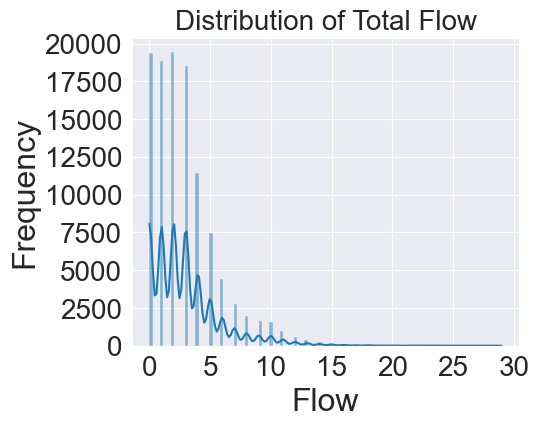

In [82]:
# plot distribution of label (flow of all nodes)
flow = label[:,:,0].reshape(-1)
plt.figure(figsize=(5, 4))
sns.histplot(flow, bins=100, kde=True)
plt.ylabel("Frequency", fontsize=23)
plt.xlabel("Flow", fontsize=23)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title("Distribution of Total Flow", fontsize=20)


In [83]:
label.shape, peoples.shape

((4590, 24, 6), (4590,))

In [84]:
# average flow rate of the inbound node:
label[:, inbound_node, :].mean()

2.7847358387799566

### Figure 7

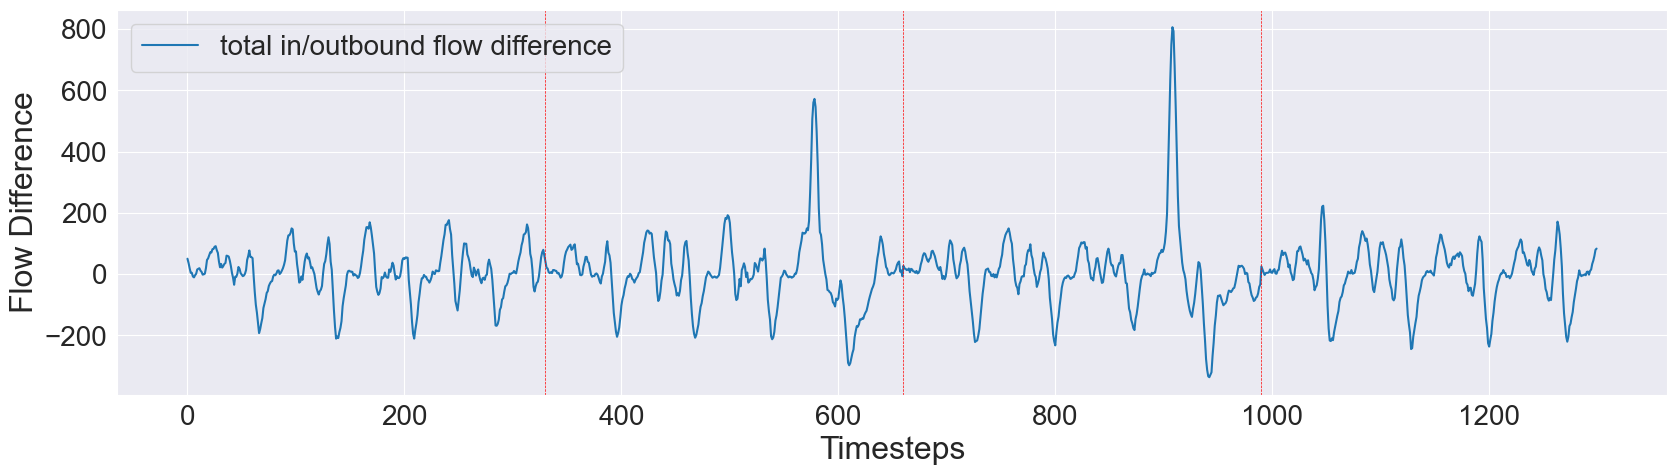

In [11]:
# visualize total flow
start = 0
time = 1300
plt.figure(figsize=(20, 5))
y = peoples[start:time]
x = np.arange(len(y))
sns.lineplot(x=x, y=y, label='total in/outbound flow difference')
plt.ylabel("Flow Difference", fontsize=23)
plt.xlabel("Timesteps", fontsize=23)
plt.legend(fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
# decide the end of sc_shift_signal according to time
sc_shift = [i - start for i in sc_shift_signal if i <= time and i  >= start]
for i in sc_shift:
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
# plt.savefig(f"./fig/{dataset_name}_total_flow_curve.pdf", bbox_inches='tight')

Online_Diffusion node 22 step 3 rmse: 2.110926262349254
Online_Diffusion node 22 step 3 rho risk: 1.8686361786961556
Online_MA node 22 step 3 rmse: 2.033237711730846
Online_MA node 22 step 3 rho risk: 1.6173999865055084
Online_Diffusion node 22 step 3 rmse: 2.110926262349254
Online_Diffusion node 22 step 3 rho risk: 1.8686361786961556
Online_LSTM node 22 step 3 rmse: 1.9868590736384155
Online_LSTM node 22 step 3 rho risk: 1.4478755933284762
Online_Diffusion node 22 step 3 rmse: 2.110926262349254
Online_Diffusion node 22 step 3 rho risk: 1.8686361786961556
Online_GCN node 22 step 3 rmse: 1.944053995188751
Online_GCN node 22 step 3 rho risk: 1.3609419335365296
Online_Diffusion node 22 step 3 rmse: 2.110926262349254
Online_Diffusion node 22 step 3 rho risk: 1.8686361786961556
Online_GAT node 22 step 3 rmse: 2.856378079239224
Online_GAT node 22 step 3 rho risk: 2.879768949387968


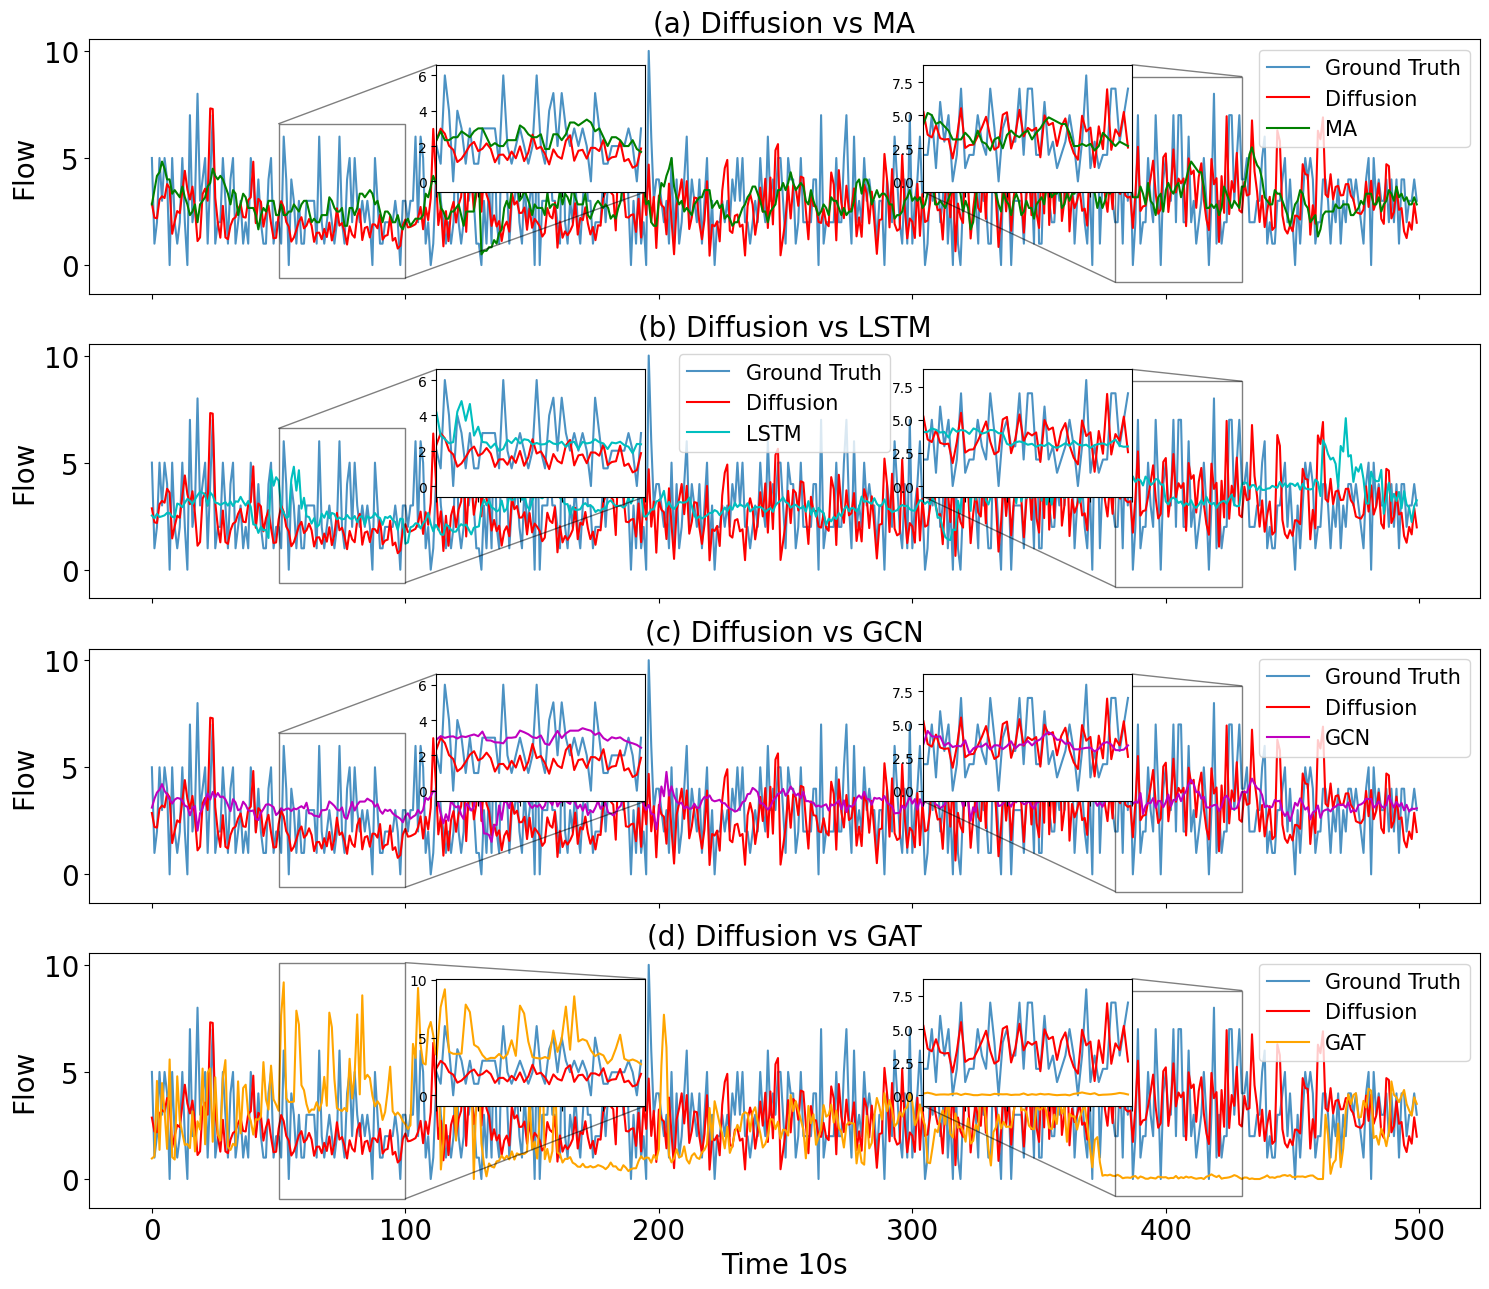

In [8]:
from lib.metric import masked_rmse_np, masked_mae_np, rho_risk, weighted_average_loss


def visualize_all(preds, label, step, node, start=0, time=1000, sc_shift_signal=None, zoom_regions=None):
    # line_types = ['-', '-.', 'dashdot', 'dashdot', 'solid', 'dashdot']
    
    models_groups = [
        ["Online_Diffusion", "Online_MA"],
        ["Online_Diffusion", "Online_LSTM"],
        ["Online_Diffusion", "Online_GCN"],
        ["Online_Diffusion", "Online_GAT"]
    ]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 13), sharex=True, sharey=True)
    x = np.arange(time - start)
    label_slice = label[start:time, node, step]

    caption = ["(a) Diffusion vs MA", "(b) Diffusion vs LSTM", "(c) Diffusion vs GCN", "(d) Diffusion vs GAT"]
    
    # Process zoom regions if specified
    if zoom_regions is not None and isinstance(zoom_regions, list) and len(zoom_regions) > 0:
        processed_zoom_regions = []
        for zoom_start, zoom_end in zoom_regions:
            # Ensure zoom region is within the data range
            adj_zoom_start = max(0, zoom_start - start)
            adj_zoom_end = min(time - start, zoom_end - start)
            processed_zoom_regions.append((adj_zoom_start, adj_zoom_end))
        zoom_regions = processed_zoom_regions
    
    for ax_idx, (ax, models) in enumerate(zip(axes, models_groups)):
        sns.lineplot(ax=ax, x=x, y=label_slice, label='Ground Truth', alpha=0.8)
        for i, mdl in enumerate(models):
            pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
            pred_slice = pred[start:time, node, step]
            if mdl == "Online_MA":
                color ='g'
            elif mdl == "Online_LSTM":
                color = 'c'
            elif mdl == "Online_GCN":
                color = 'm'
            elif mdl == "Online_GAT":
                color = 'orange'
            else:
                color = 'r'
            sns.lineplot(ax=ax, x=x, y=pred_slice, label=mdl.split("_")[1], linestyle="-", color=color)
            ax.grid(False)
            rmse = np.sqrt(np.mean((label_slice - pred_slice) ** 2))
            print(f"{mdl} node {node} step {step} rmse: {rmse}")
            rr = rho_risk(pred_slice, label_slice, timespan=1, rho=0.9)
            rr = np.mean(rr)
            print(f"{mdl} node {node} step {step} rho risk: {rr}")
        
        if sc_shift_signal is not None:
            sc_shift = [i - start for i in sc_shift_signal if i <= time and i >= start]
            for i in sc_shift:
                ax.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
        
        # Add inset axes for the zoom regions if specified
        if zoom_regions is not None:
            # Define positions for the two insets
            inset_positions = [
                [0.25, 0.4, 0.15, 0.5],  # [x, y, width, height] for first inset
                [0.6, 0.4, 0.15, 0.5]   # [x, y, width, height] for second inset
            ]
            
            for region_idx, (zoom_start, zoom_end) in enumerate(zoom_regions[:2]):  # Limit to 2 regions
                # Create inset axes
                axins = ax.inset_axes(inset_positions[region_idx])
                
                # Plot the same data on the inset axes
                axins.plot(x[zoom_start:zoom_end], label_slice[zoom_start:zoom_end], label='Ground Truth', alpha=0.8)
                for i, mdl in enumerate(models):
                    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
                    pred_slice = pred[start:time, node, step]
                    if mdl == "Online_MA":
                        color ='g'
                    elif mdl == "Online_LSTM":
                        color = 'c'
                    elif mdl == "Online_GCN":
                        color = 'm'
                    elif mdl == "Online_GAT":
                        color = 'orange'
                    else:
                        color = 'r'
                    axins.plot(x[zoom_start:zoom_end], pred_slice[zoom_start:zoom_end], color=color)
                
                # Set the limits of the inset axes
                axins.set_xlim(x[zoom_start], x[zoom_end])
                
                # Optionally adjust y-limits to focus on the peak
                y_min = min(label_slice[zoom_start:zoom_end].min(), 
                           min([pred[start:time, node, step][zoom_start:zoom_end].min() for mdl in models]))
                y_max = max(label_slice[zoom_start:zoom_end].max(), 
                           max([pred[start:time, node, step][zoom_start:zoom_end].max() for mdl in models]))
                margin = (y_max - y_min) * 0.1  # 10% margin
                axins.set_ylim(y_min - margin, y_max + margin)
                
                # Remove ticks for cleaner appearance
                axins.tick_params(labelleft=True, labelbottom=False)
                
                # Add a box to show the zoomed region in the original plot
                ax.indicate_inset_zoom(axins, edgecolor="black")
        
        ax.legend(fontsize=15)
        ax.set_title(caption.pop(0), fontsize=20)
        ax.set_ylabel("Flow", fontsize=20)
        ax.set_xlabel("Time 10s", fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=20)
    
    plt.tight_layout()
    # plt.savefig(f"./fig/{dataset_name}_node{node}_step_{step}_start{start}_end{time}_flow_curve_zoom.pdf", bbox_inches='tight')
    plt.show()

# Example call with two zoom regions
visualize_all(preds, label, step=3, node=22, start=500, time=1000,
              sc_shift_signal=None, 
              zoom_regions=[(550, 600), (880, 930)])  # Two different regions to zoom in on

### Figure 6 rmse 5.15, mae 4.08

Online_Diffusion node 22 step 0 rmse: 2.426514106719315
Online_Diffusion node 22 step 0 rho risk: 2.2186218434333806
Online_MA node 22 step 0 rmse: 2.3700210839335036
Online_MA node 22 step 0 rho risk: 1.9365333263754845
Online_Diffusion node 22 step 0 rmse: 2.426514106719315
Online_Diffusion node 22 step 0 rho risk: 2.2186218434333806
Online_LSTM node 22 step 0 rmse: 2.4456529581794864
Online_LSTM node 22 step 0 rho risk: 2.41504933629036
Online_Diffusion node 22 step 0 rmse: 2.426514106719315
Online_Diffusion node 22 step 0 rho risk: 2.2186218434333806
Online_GCN node 22 step 0 rmse: 2.5513960140933003
Online_GCN node 22 step 0 rho risk: 2.623504144001007
Online_Diffusion node 22 step 0 rmse: 2.426514106719315
Online_Diffusion node 22 step 0 rho risk: 2.2186218434333806
Online_GAT node 22 step 0 rmse: 2.5896199025203135
Online_GAT node 22 step 0 rho risk: 2.4142105159640312


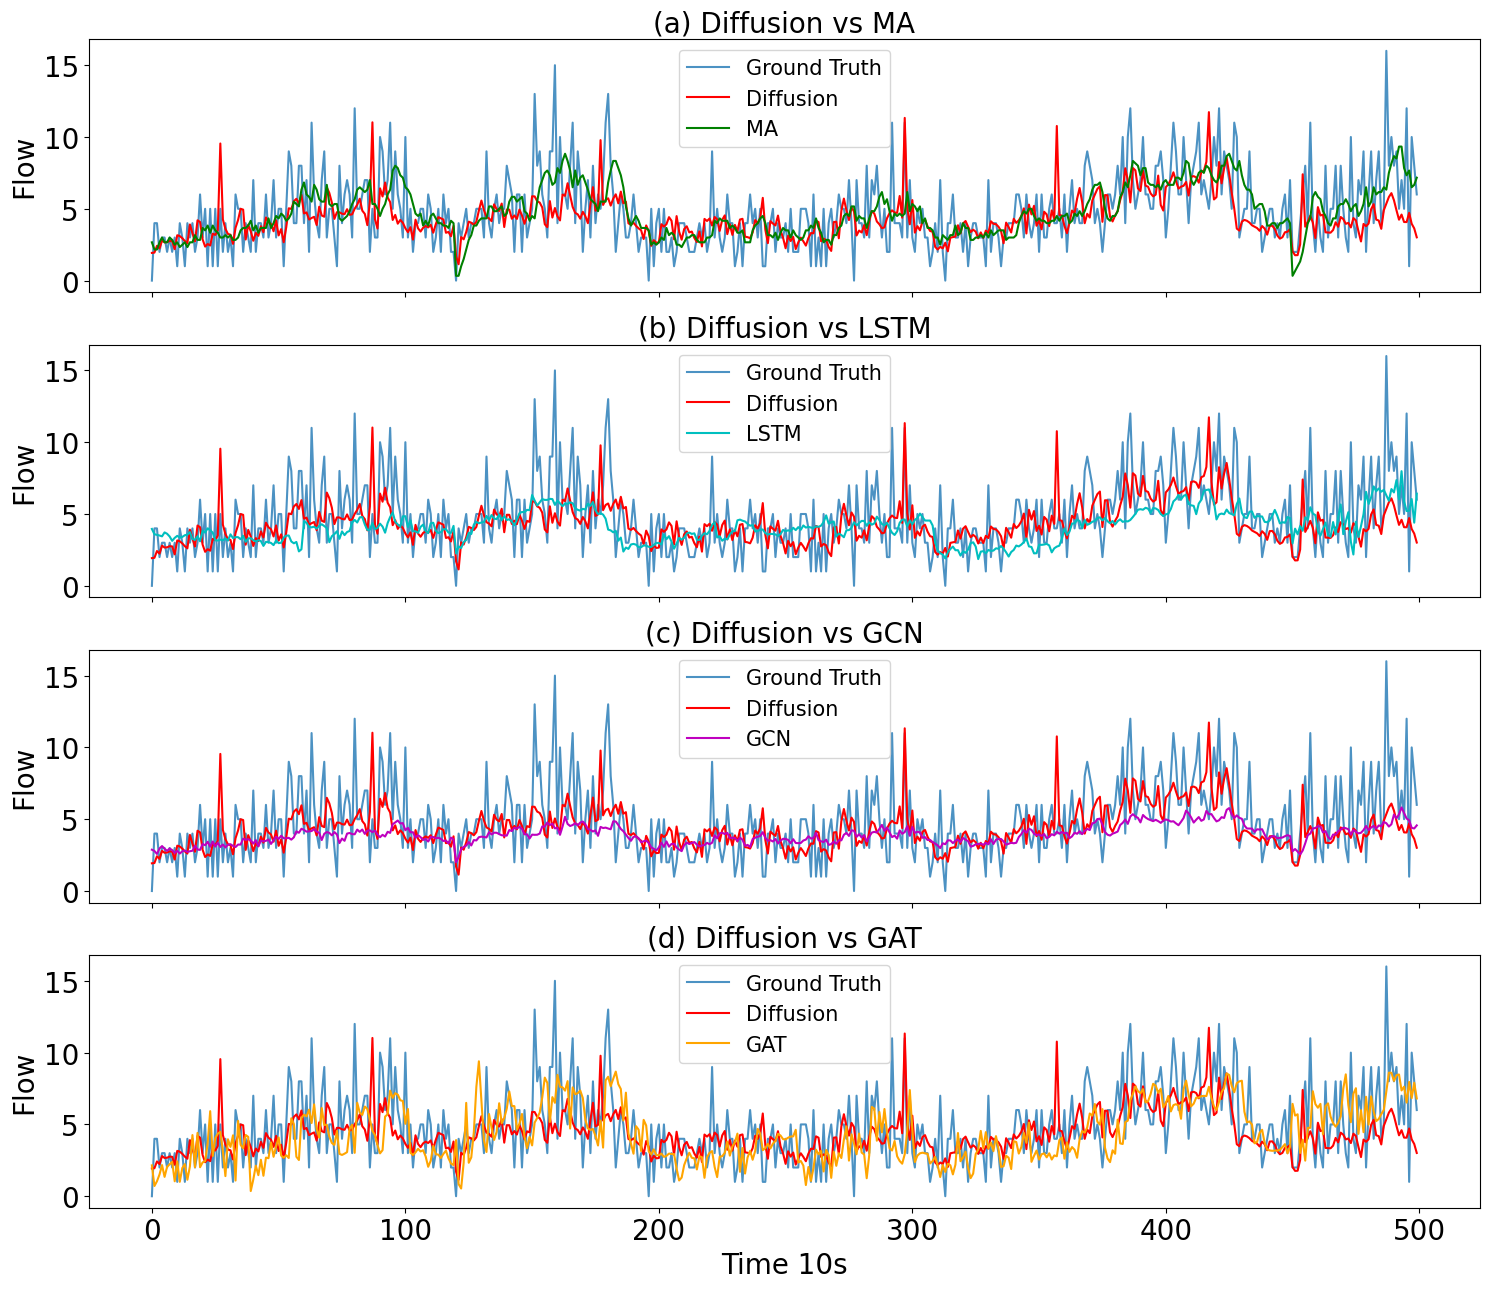

In [9]:

def visualize_all(preds, label, step, node, start=0, time=1000, sc_shift_signal=None):
    line_types = ['-', '-.', 'dashdot', 'dashdot', 'solid', 'dashdot']
    
    models_groups = [
        ["Online_Diffusion", "Online_MA"],
        ["Online_Diffusion", "Online_LSTM"],
        ["Online_Diffusion", "Online_GCN"],
        ["Online_Diffusion", "Online_GAT"]
    ]
    
    # models_groups = [
    #     ["Online_Diffusion_plus", "Online_MA"],
    #     ["Online_Diffusion_plus", "Online_LSTM"],
    #     ["Online_Diffusion_plus", "Online_GCN"],
    #     ["Online_Diffusion_plus", "Online_GAT"]
    # ]
    
    fig, axes = plt.subplots(4, 1, figsize=(15, 13), sharex=True, sharey=True)
    x = np.arange(time - start)
    label_slice = label[start:time, node, step]

    caption = ["(a) Diffusion vs MA", "(b) Diffusion vs LSTM", "(c) Diffusion vs GCN", "(d) Diffusion vs GAT"]
    for ax, models in zip(axes, models_groups):
        sns.lineplot(ax=ax, x=x, y=label_slice, label='Ground Truth', alpha=0.8)
        for i, mdl in enumerate(models):
            pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
            pred_slice = pred[start:time, node, step]
            if mdl == "Online_MA":
                color ='g'
            elif mdl == "Online_LSTM":
                color = 'c'
            elif mdl == "Online_GCN":
                color = 'm'
            elif mdl == "Online_GAT":
                color = 'orange'
            else:
                color = 'r'
            # sns.lineplot(ax=ax, x=x, y=pred_slice, label=mdl.split("_")[1], linestyle=line_types[i], color=color)
            sns.lineplot(ax=ax, x=x, y=pred_slice, label=mdl.split("_")[1], linestyle="-", color=color)
            # no grids
            ax.grid(False)
            #calculate rmse between pred and label
            rmse = np.sqrt(np.mean((label_slice - pred_slice) ** 2))
            print(f"{mdl} node {node} step {step} rmse: {rmse}")
            # rho risk
            rr = rho_risk(pred_slice, label_slice, timespan=1, rho=0.9)
            rr = np.mean(rr)
            print(f"{mdl} node {node} step {step} rho risk: {rr}")
        
        if sc_shift_signal is not None:
            sc_shift = [i - start for i in sc_shift_signal if i <= time and i >= start]
            for i in sc_shift:
                ax.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
        
        ax.legend(fontsize=15)
        ax.set_title(caption.pop(0), fontsize=20)
        # y,x title
        ax.set_ylabel("Flow", fontsize=20)
        ax.set_xlabel("Time 10s", fontsize=20)
        # ticks
        ax.tick_params(axis='both', which='major', labelsize=20)
    plt.tight_layout()
    # save figure
    # plt.savefig(f"./fig/{dataset_name}_node{node}_step_{step}_start{start}_end{time}_flow_curve.pdf", bbox_inches='tight')
    plt.show()


# Example call to the function
# Assuming sc_shift_signal is defined elsewhere in your code
# visualize_all(preds, label, 3, 22, start=500, time=1000, sc_shift_signal=None)  # for figure 6
visualize_all(preds, label,0, 22, start=1500, time=2000, sc_shift_signal=None)  # for figure 6
# visualize_all(preds, label, step=3, node=5, start=500, time=1000, sc_shift_signal=None)  # for appendix

In [39]:
preds["Online_Diffusion"].shape, label.shape

((153, 24, 30, 6), (24, 349, 6))

Online_Diffusion node 1 step 2 rmse: 1.8063431260949705


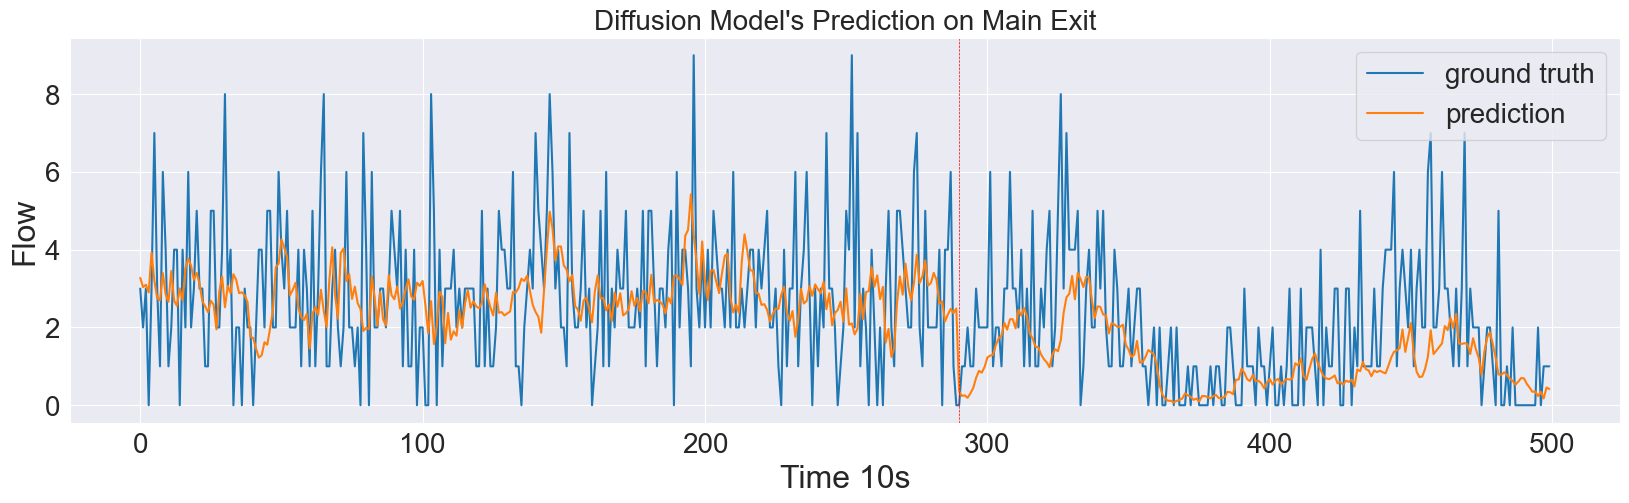

In [7]:
node_id = 1
step = 2
start = 1000
time = 1500
visualize("Online_Diffusion", preds, label, step, node_id, start=start, time=time)

Online_Diffusion_plus node 1 step 3 rmse: 2.6337012490137908


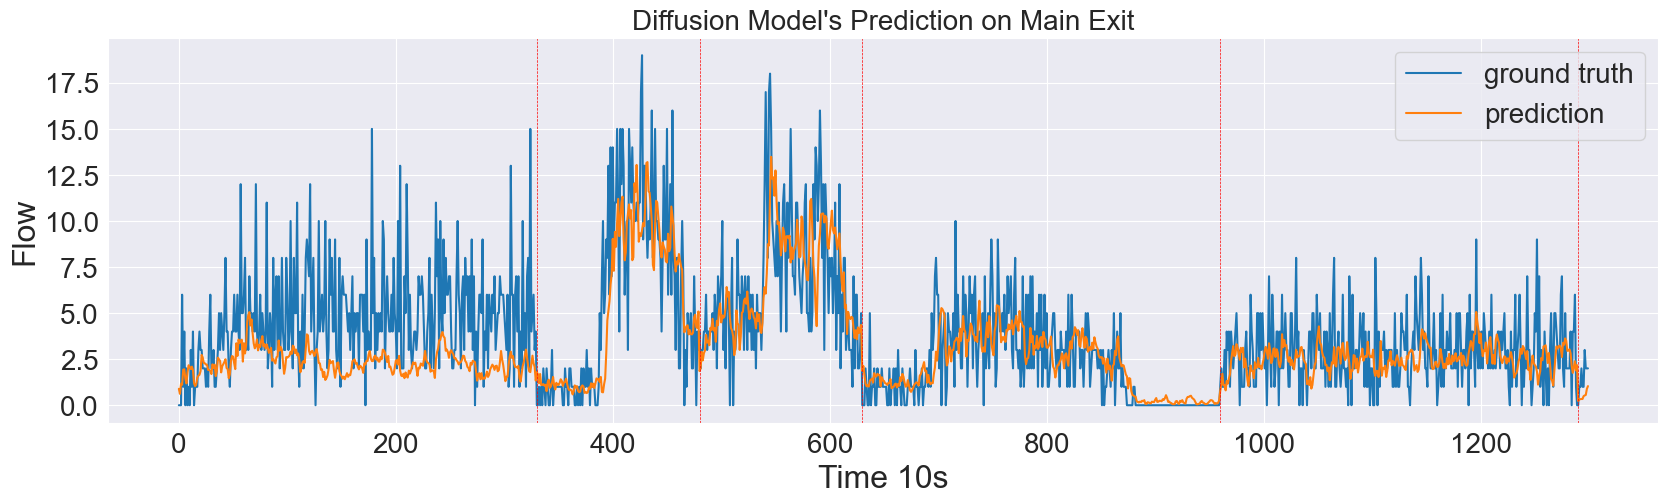

In [20]:
visualize("Online_Diffusion_plus", preds, label, step, node_id, start=start, time=time)

Online_Diffusion_UQ node 1 step 5 rmse: 5.519790427125426


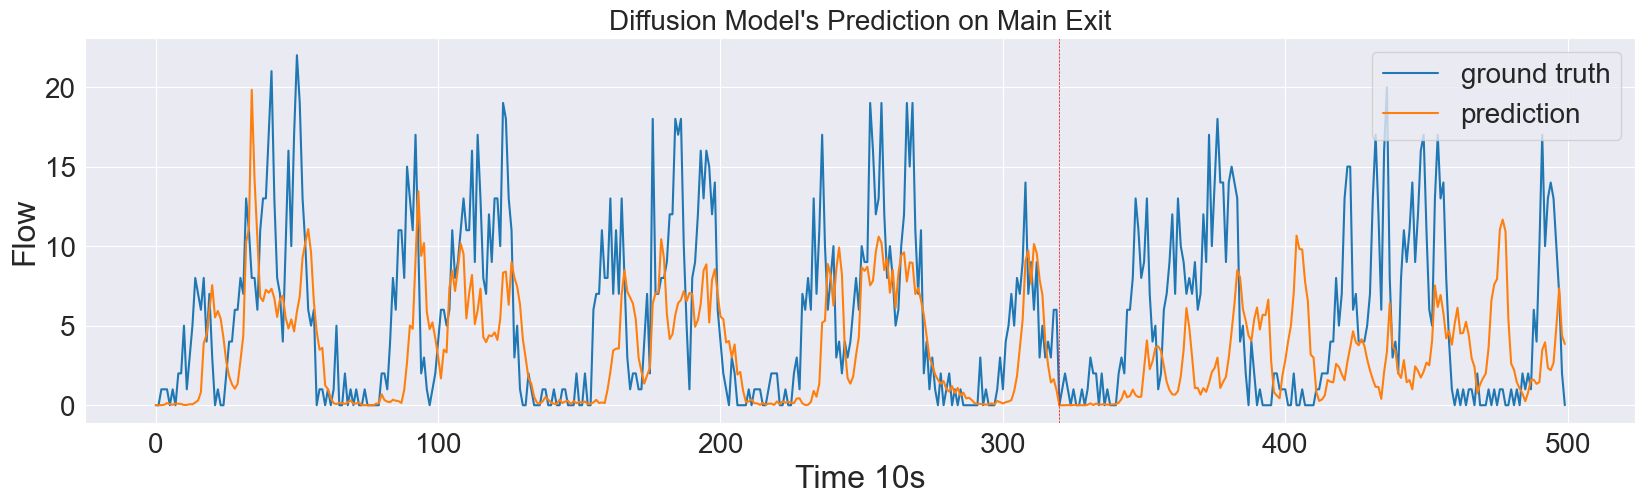

In [32]:
visualize("Online_Diffusion_UQ", preds, label, step, node_id, start=start, time=time)

Online_LSTM node 1 step 2 rmse: 2.944916607311054


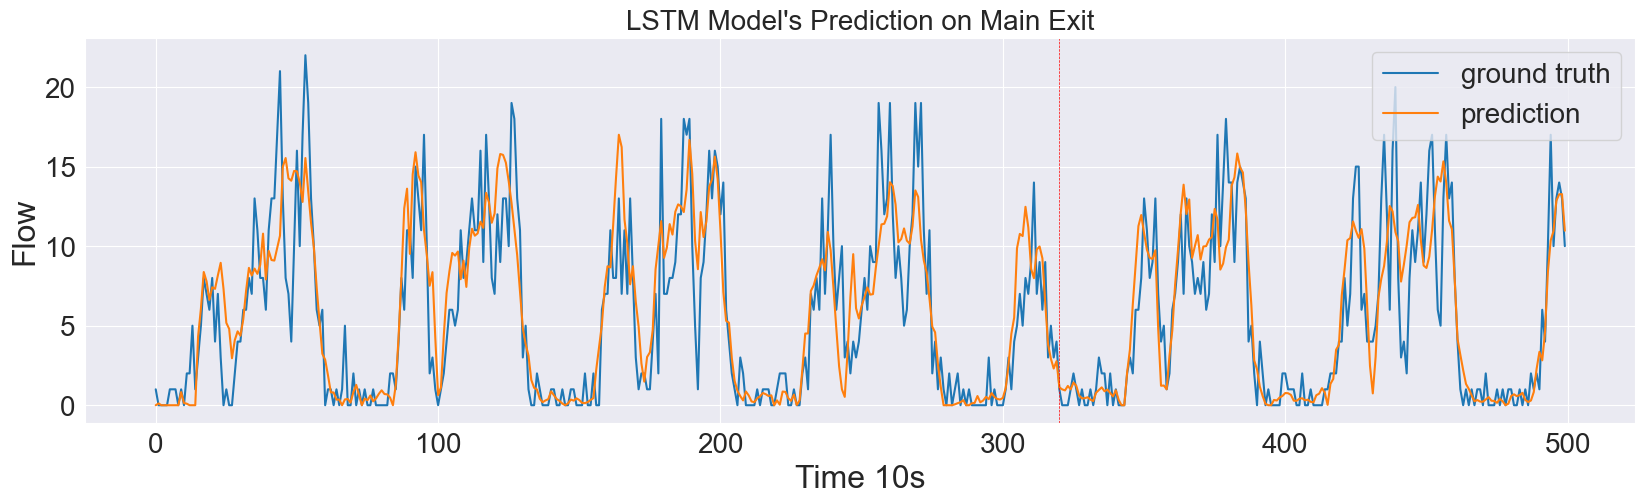

In [10]:
visualize("Online_LSTM", preds, label, step, node_id, start=start, time=time, save=False)

Online_GCN node 1 step 2 rmse: 4.43546858914415


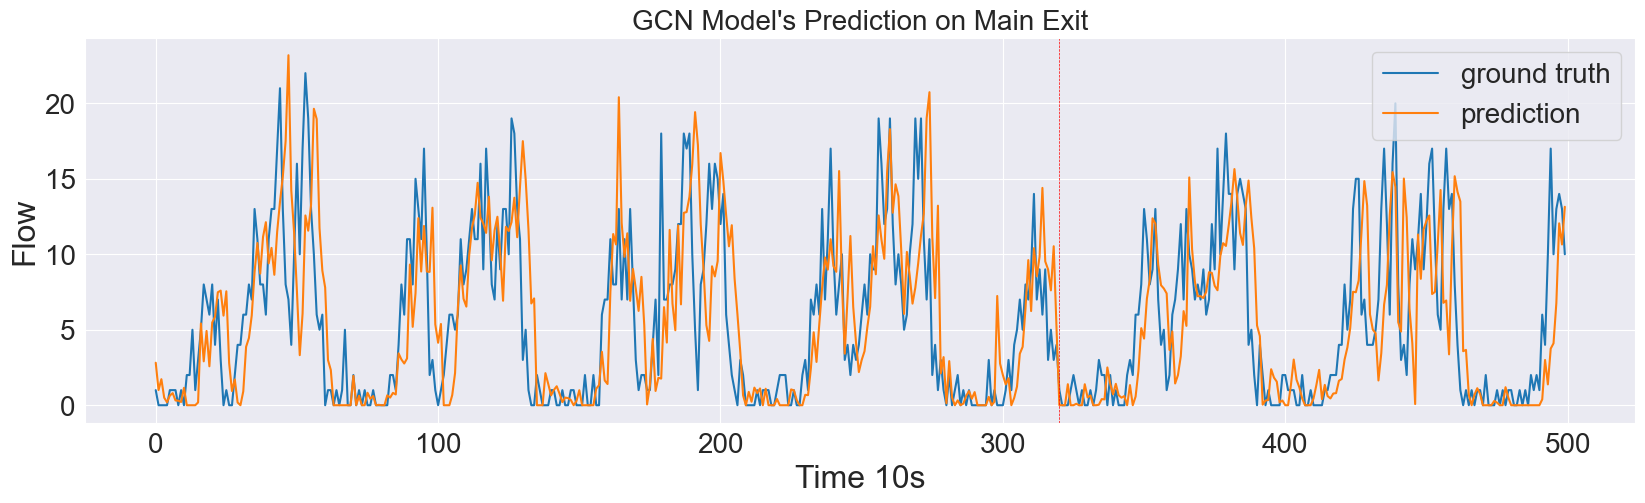

In [11]:
visualize("Online_GCN", preds, label, step, node_id, start=start, time=time, save=False)

Online_GCNLSTM node 1 step 2 rmse: 3.471805201543241


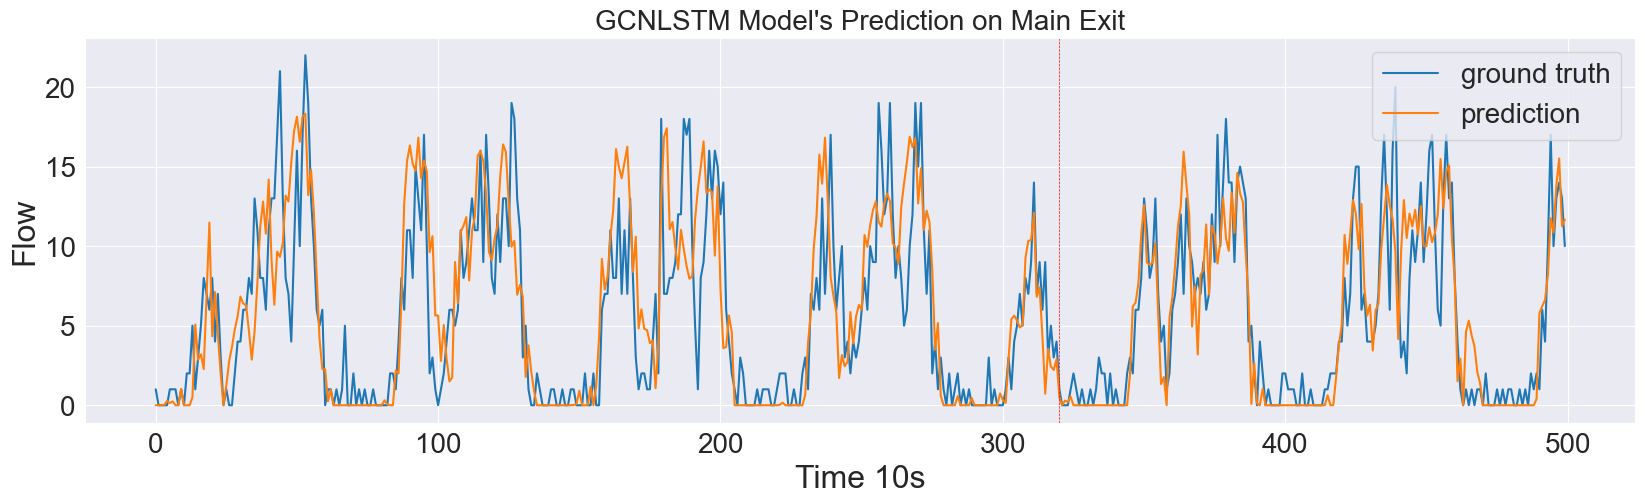

In [12]:
visualize("Online_GCNLSTM", preds, label, step, node_id, start=start, time=time)

Online_MA node 1 step 2 rmse: 1.813351841629289


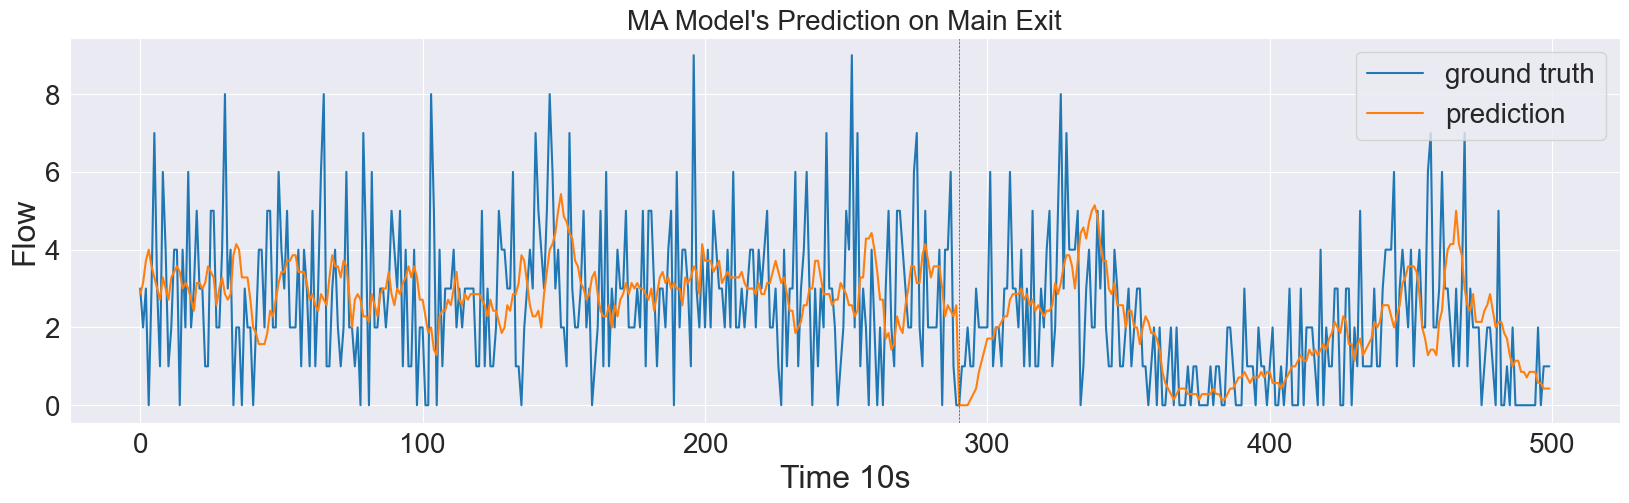

In [8]:
visualize("Online_MA", preds, label, step, node_id, start=start, time=time)

Online_GAT node 1 step 0 rmse: 0.6703738199507758


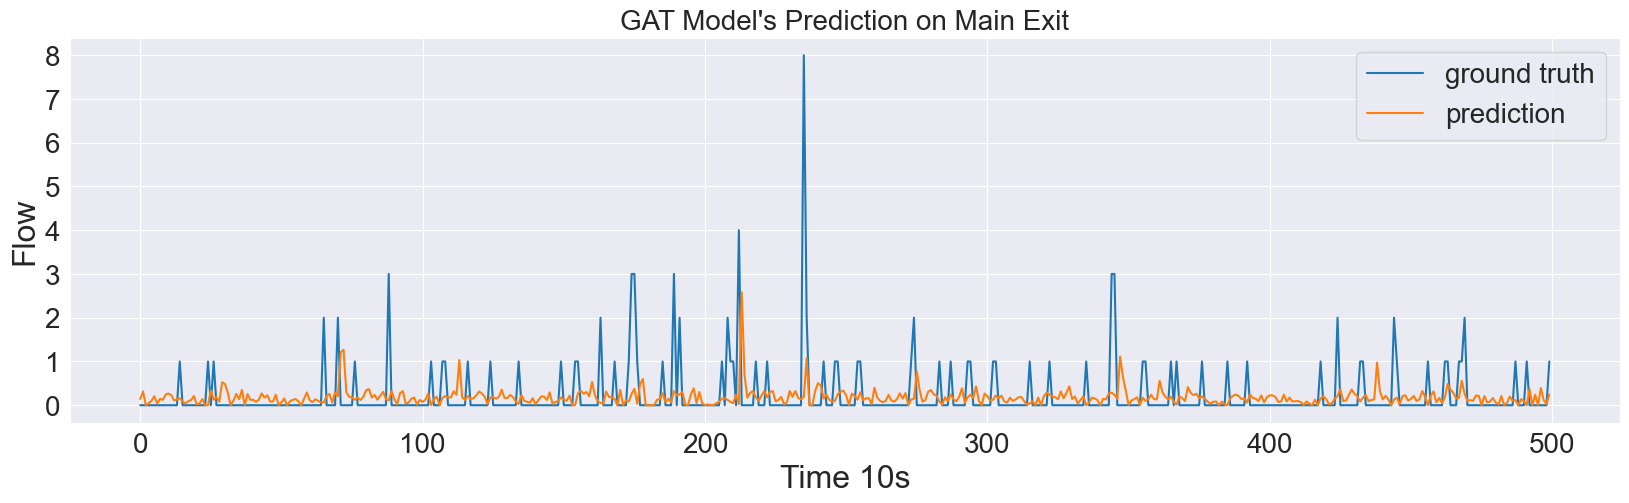

In [11]:
visualize("Online_GAT", preds, label, step, node_id, start=start, time=time, save=False)

In [49]:
# error per step
from lib.metric import masked_rmse_np, masked_mae_np, rho_risk
error_per_step_dict = {}
for mdl in preds.keys():
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    error_per_step = []
    for i in range(pred.shape[2]): # on step dimension
        error_per_step.append(masked_rmse_np(pred[:, node_of_interest, i], label[:, node_of_interest, i]))
        # error_per_step.append(np.mean((pred[:, node_of_interest, i] - label[:, node_of_interest, i].numpy()) ** 2))
        # mae
        # error_per_step.append(np.mean(np.abs(pred[:, :, i] - label[:, :, i].numpy())))
    error_per_step_dict[mdl] = np.array(error_per_step)

In [37]:
node_of_interest

[1, 2, 4, 7]

### Prediction error for table 2
- preds: dictionary of model_name. preds[model_name]: [num_chunks, num_nodes, chunk_size, horizon]
- label: [num_samples, num_nodes, horizon]
- preds_cat: dictionary of model_name. preds_cat[model_name]: [num_nodes, num_scenarios*chunk_size, horizon]

In [25]:
dataset_name, chunk_size, pred_horizon

('maze', 30, 7)

In [9]:
# load pred_cat and label_cat for main experiment comparison
# mdls = ["Online_Diffusion", "Online_Diffusion_plus", "Online_GCN", "Online_LSTM", "Online_GAT", "Online_MA"]
mdls = ["Online_Diffusion", "Online_Diffusion_UQ", "Online_GCN", "Online_LSTM", "Online_GAT", "Online_MA", "Online_GCNLSTM"]
preds_cat = {}
label_cat = {}
chunk_size = 30
for mdl in mdls:
    try:
        preds_cat[mdl] = np.load(f"./checkpoint/{mdl}_{dataset_name}_pred_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        label_cat[mdl] = np.load(f"./checkpoint/{mdl}_{dataset_name}_label_cat_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        preds_cat[mdl][preds_cat[mdl] < 0] = 0
    except:
        print(f"model_{mdl}, file not found")
        continue


model_Online_Diffusion_UQ, file not found
model_Online_GCN, file not found
model_Online_LSTM, file not found
model_Online_GAT, file not found
model_Online_GCNLSTM, file not found


In [37]:
def quantile_loss_adjusted(pred, target, quantile):
    """
    Calculate adjusted quantile loss for evaluation.

    Args:
        pred (numpy.ndarray): Predicted values.
        target (numpy.ndarray): Actual target values.
        quantile (float): Quantile value (e.g., 0.9 to heavily penalize underestimations).

    Returns:
        float: Adjusted quantile loss.
    """
    errors = pred - target
    idx = np.where(errors > 0)

    loss = np.abs(errors) * ((quantile * (np.sign(target - pred)+1) + (1-quantile) * (np.sign(pred - target)+1)))/2
    return np.mean(loss)

In [12]:
# overall error for pred_cat and label cat, this is the one I used in the paper
from lib.metric import weighted_average_loss
step = 1
for mdl in mdls:
    try:
        pred = preds_cat[mdl]
        #rmse
        print(f"{mdl} rmse: {masked_rmse_np(pred[node_of_interest,:, :step], label_cat[mdl][node_of_interest,:, :step])}")
        # mae
        # print(f"{mdl} mae: {np.mean(np.abs(pred[:, node_of_interest, :] - label_cat[mdl][:, node_of_interest, :]))}")
        print(f"{mdl} mae: {masked_mae_np(pred[node_of_interest,:, :step], label_cat[mdl][node_of_interest,:, :step])}")
        # quantile 0.9
        rr = rho_risk(pred[node_of_interest,:, :step], label_cat[mdl][node_of_interest,:, :step], timespan=3, rho=0.9)
        rr = np.mean(rr)
        print(f"{mdl} quantile loss: {rr}")
        q_l = quantile_loss_adjusted(preds_cat[mdl][node_of_interest,:, :step].reshape([1, -1]), label_cat[mdl][node_of_interest,:, :step].reshape([1, -1]), quantile=0.9)
        print(f"{mdl} qt loss: {q_l}")
        wt_loss, _, _ = weighted_average_loss(preds_cat[mdl][node_of_interest,:, :step], label_cat[mdl][node_of_interest,:, :step], timespan=2, rho=0.90)
        print(f"{mdl} wt loss: {wt_loss}")
    except:
        print(f"{mdl} not found")

Online_Diffusion rmse: 1.988383173942566
Online_Diffusion mae: 1.402740478515625
Online_Diffusion quantile loss: 3.181349039077759
Online_Diffusion not found
Online_Diffusion_UQ not found
Online_GCN not found
Online_LSTM not found
Online_GAT not found
Online_MA rmse: 1.904325008392334
Online_MA mae: 1.3358409404754639
Online_MA quantile loss: 2.5762736797332764
Online_MA not found
Online_GCNLSTM not found


In [12]:
# overall error for truncated pred and label
from lib.metric import masked_rmse_np, masked_mae_np, rho_risk
for mdl in model_list:
    # print(mdl)
    if mdl in ["Online_Diffusion_plus", "Online_Diffusion_UQ"]:
        continue
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    #rmse
    print(f"{mdl} rmse: {masked_rmse_np(pred[:, node_of_interest, :], label[:, node_of_interest, :])}")
    # mae
    # print(f"{mdl} mae: {np.mean(np.abs(pred[:, node_of_interest, :] - label[:, node_of_interest, :]))}")
    print(f"{mdl} mae: {masked_mae_np(pred[:, node_of_interest, :], label[:, node_of_interest, :])}")
    # quantile 0.9
    rr = rho_risk(pred[:, node_of_interest, :], label[:, node_of_interest, :], timespan=1, rho=0.95)
    rr = np.mean(rr)
    wt_loss,_, _ = weighted_average_loss(pred[:, node_of_interest, :], label[:, node_of_interest, :], timespan=1, rho=0.95)
    print(f"{mdl} quantile loss: {rr}")
    print(f"{mdl} wt loss: {wt_loss}")


Online_Diffusion rmse: 2.0958778858184814
Online_Diffusion mae: 1.4720333814620972
Online_Diffusion quantile loss: 1.732158932575922
Online_Diffusion wt loss: 1.617846361809938
Online_MA rmse: 1.989479660987854
Online_MA mae: 1.3935010433197021
Online_MA quantile loss: 1.4208561020822124
Online_MA wt loss: 1.4081616578659542
Online_GCN rmse: 2.2504281997680664
Online_GCN mae: 1.6444884538650513
Online_GCN quantile loss: 1.603563166209101
Online_GCN wt loss: 1.664473041744112
Online_GAT rmse: 2.1189558506011963
Online_GAT mae: 1.5044001340866089
Online_GAT quantile loss: 1.51098628833749
Online_GAT wt loss: 1.521201356415762
Online_LSTM rmse: 2.1486940383911133
Online_LSTM mae: 1.5183954238891602
Online_LSTM quantile loss: 1.51973726852853
Online_LSTM wt loss: 1.520649628030978
Online_GCNLSTM rmse: 2.3628242015838623
Online_GCNLSTM mae: 1.6440259218215942
Online_GCNLSTM quantile loss: 1.8417238041012118
Online_GCNLSTM wt loss: 1.7618493994390672


In [ ]:
# plot error per step
plt.figure(figsize=(10, 5))
for mdl in error_per_step_dict.keys():
    sns.lineplot(x=np.arange(error_per_step_dict[mdl].shape[0]), y=error_per_step_dict[mdl], label=mdl)
    print(f"{mdl} rmse: {np.mean(error_per_step_dict[mdl])}")
    plt.ylabel("RMSE")
    plt.xlabel("Step")
    # plt.ylim(0, 20)

In [65]:
# plot error per node using pred and label
from lib.metric import masked_rmse_np

error_per_node_dict = {}
for mdl in preds.keys():
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    error_per_node = []
    for i in node_of_interest: # on node dimension
        error_per_node.append(masked_rmse_np(pred[:, i, :], label[:, i, :].numpy()))
        # mse
        # error_per_node.append(np.mean((pred[:, i, :] - label[:, i, :].numpy()) ** 2))
        # mape
        # error_per_node.append(masked_mape_np(pred[:, i, :], label[:, i, :].numpy()))
    error_per_node_dict[mdl] = np.array(error_per_node)
    

Online_Diffusion rmse: 2.0184085369110107
Online_MA rmse: 1.974818468093872
Online_GCN rmse: 2.2290937900543213
Online_GAT rmse: 2.0501937866210938
Online_LSTM rmse: 2.125643491744995
Online_GCNLSTM rmse: 2.2153213024139404


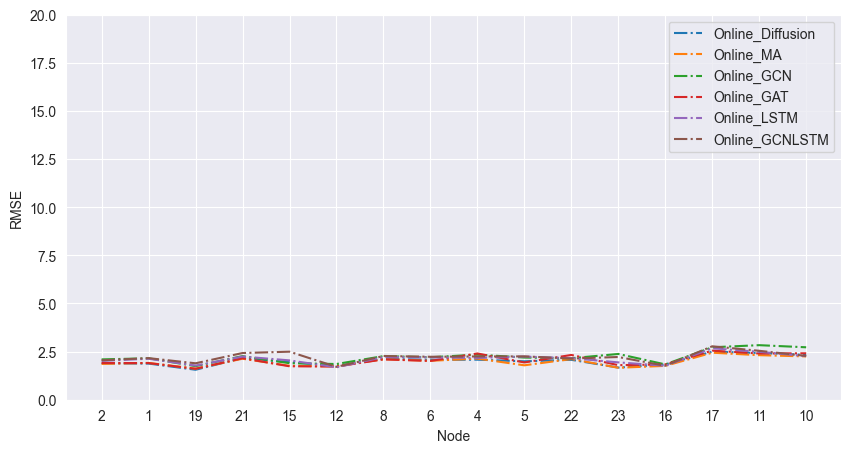

In [66]:
# plot error per node
plt.figure(figsize=(10, 5))
for mdl in error_per_node_dict.keys():
    # change the line style
    sns.lineplot(x=np.arange(error_per_node_dict[mdl].shape[0]), y=error_per_node_dict[mdl], label=mdl, linestyle='-.')
    print(f"{mdl} rmse: {np.mean(error_per_node_dict[mdl])}")
    plt.xticks(np.arange(len(node_of_interest)), node_of_interest)
    plt.ylabel("RMSE")
    plt.xlabel("Node")
    plt.ylim(0, 20)


## Error Visualization on Graph

In [14]:
pos = {
    0: (10, 100),
    1: (20, 100),
    2: (0, 90),
    3: (0, 80),
    4: (10, 50),
    5: (20, 50),
    6: (0, 30),
    7: (0, 20),
    8: (10, 0),
    9: (20, 0),
    10: (50, 30),
    11: (50, 20),
    12: (70, 0),
    13: (80, 0),
    14: (110, 30),
    15: (110, 20),
    16: (70, 50),
    17: (80, 50),
    18: (70, 100),
    19: (80, 100),
    20: (110, 90),
    21: (110, 80),
    22: (50, 90),
    23: (50, 80),
}
G = g.to_networkx()

In [48]:
# sc predcition error
sc_id = 2 # 1(cong), 2(cong), 3(normal)
if sc_id == 0:
    start = 0
    end = sc_shift_signal[sc_id]
else:
    start = sc_shift_signal[sc_id-1]
    end = sc_shift_signal[sc_id]
sc_error_per_node_dict = {}
for mdl in preds.keys():
    pred = np.transpose(preds[mdl], [0, 2, 1, 3]).reshape(-1, preds[mdl].shape[1], preds[mdl].shape[3])
    sc_error_per_node = []
    for i in node_of_interest: # on node dimension
        sc_error_per_node.append(masked_rmse_np(pred[start:end, i, :], label[start:end, i, :]))
        # mse
        # error_per_node.append(np.mean((pred[:, i, :] - label[:, i, :].numpy()) ** 2))
        # mape
        # error_per_node.append(masked_mape_np(pred[:, i, :], label[:, i, :].numpy()))
    sc_error_per_node_dict[mdl] = np.array(sc_error_per_node)
errors_all_node_dict = {}

# all node
for mdl in sc_error_per_node_dict.keys():
    error_all_nodes = np.zeros(g.number_of_nodes())
    for i, node in enumerate(node_of_interest):
        error_all_nodes[node] = sc_error_per_node_dict[mdl][i]
    errors_all_node_dict[mdl] = error_all_nodes

In [67]:
error_dict["Online_Diffusion"].shape

(415, 1)

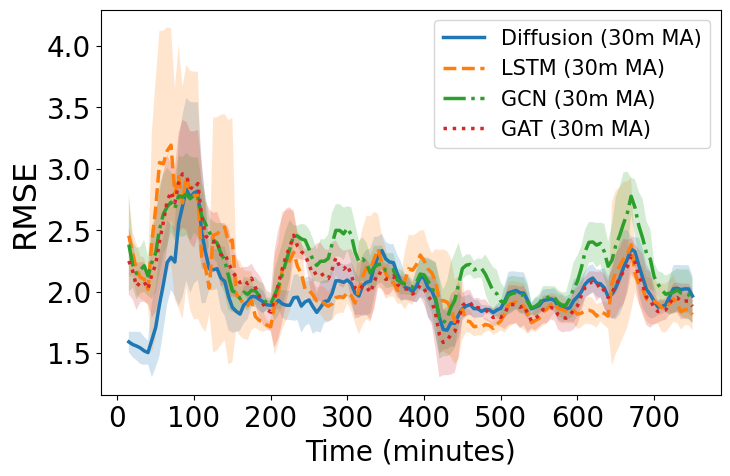

In [110]:
# Convert x-axis to hours and minutes
line_types = ['-', '--', '-.', ':']
plt.figure(figsize=(8, 5))
mdl_names = ["Online_Diffusion", "Online_LSTM", "Online_GCN", "Online_GAT"]

window_size = 6  # 30-minute moving average (6 * 5 minutes)

for i, mdl_name in enumerate(mdl_names):
    data = error_dict[mdl_name][:, 0]
    
    # Calculate moving average
    ma = np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    x_ma = np.arange(len(ma)) * 5 + (window_size//2) * 5
    
    # Calculate moving standard deviation
    std = np.array([np.std(data[max(0, i-window_size):i]) 
                   for i in range(window_size, len(data)+1)])
    
    # Plot moving average with std interval
    plt.plot(x_ma, ma, 
             linestyle=line_types[i],
             linewidth=2.5,
             label=f"{mdl_name.split('_')[1]} (30m MA)")
    
    # Add std interval
    plt.fill_between(x_ma, 
                     ma - std, 
                     ma + std, 
                     alpha=0.2)  # Adjust alpha for transparency

# Rest of your plotting code (axes, labels, etc.)
plt.ylabel("RMSE", fontsize=23)
plt.xlabel("Time (minutes)", fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.legend(fontsize=15)
plt.grid(False)
# plt.savefig(f"./fig/{dataset_name}_error_curve_ma.pdf", bbox_inches='tight')

### Visualize sequential error, for figure 5

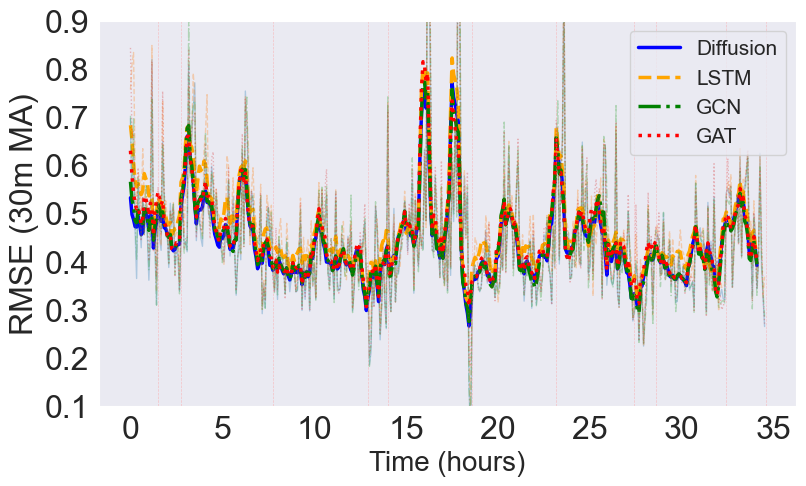

In [62]:
# Convert x-axis to hours and minutes
line_types = ['-', '--', '-.', ':']
plt.figure(figsize=(9, 5))
mdl_names = ["Online_Diffusion", "Online_LSTM", "Online_GCN", "Online_GAT"]
colors = ['blue','orange', 'green', 'red']

# for i, mdl_name in enumerate(mdl_names):
#     sns.lineplot(x=np.arange(len(error_dict[mdl_name])) * 5 / 60,  # Convert to hours
#                  y=error_dict[mdl_name][:, 0], 
#                  label=mdl_name.split("_")[1], 
#                  linestyle=line_types[i])
    
window_size = 6  # 1-hour moving average (12 * 5 minutes)
for i, mdl_name in enumerate(mdl_names):
    # Original line (thinner)
    sns.lineplot(x=np.arange(len(error_dict[mdl_name])) * 5/60,
                 y=error_dict[mdl_name][:, 0], 
                 label='_nolegend_',
                 linestyle=line_types[i],
                 alpha=0.3,
                 linewidth=1)
    
    # Moving average line (thicker)
    ma = np.convolve(error_dict[mdl_name][:, 0], 
                     np.ones(window_size)/window_size, 
                     mode='valid')
    x_ma = np.arange(len(ma)) * 5/60
    plt.plot(x_ma, ma, 
             linestyle=line_types[i],
             linewidth=2.5,
             color=colors[i],
             label=f"{mdl_name.split('_')[1]}")

# Plot scenario shift lines aligned with minutes
for i in sc_shift_signal:
    shift_time = (i//chunk_size) * 5/60  # Convert to minutes (not hours)
    plt.axvline(x=shift_time, color=(1.0, 0.6, 0.6), linestyle='--', linewidth=0.5, alpha=0.5)

plt.ylabel("RMSE (30m MA)", fontsize=23)
plt.yticks(fontsize=23)
plt.xticks(fontsize=23)
plt.xlabel("Time (hours)", fontsize=20)
plt.grid(False)
if dataset_name == "crossroad":
    plt.ylim(0, 30)
elif dataset_name == "train_station":
    plt.ylim(0, 10)
elif dataset_name == "edinburgh":
    plt.ylim(0.1, 0.9)

# Adjust legend
plt.legend(fontsize=15)
# plt.savefig(f"./fig/{dataset_name}_error_curve_ma.pdf", bbox_inches='tight')

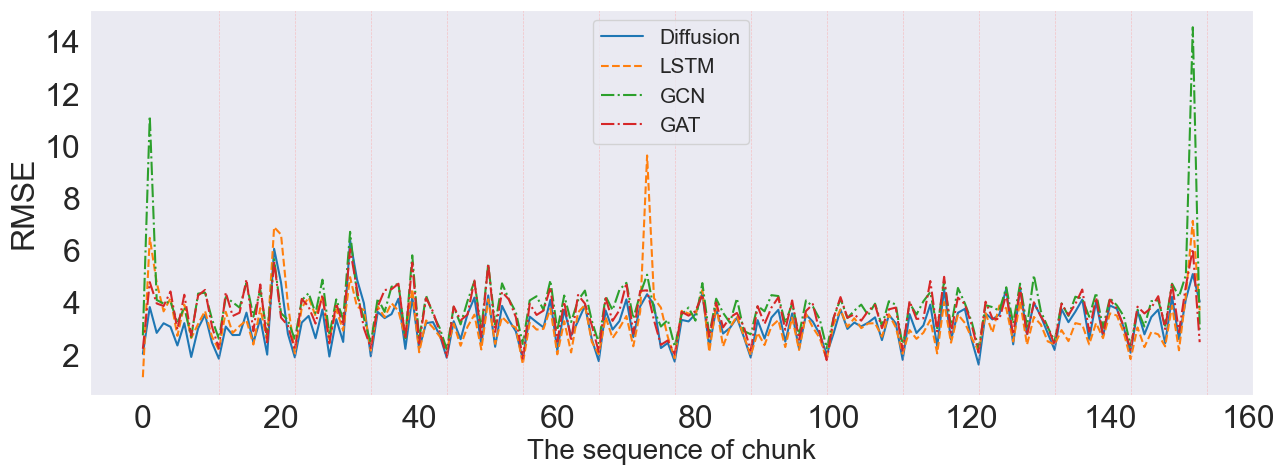

In [113]:
line_types = ['-', '--', '-.', '-.', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(15, 5))
mdl_names = ["Online_Diffusion", "Online_LSTM", "Online_GCN", "Online_GAT"]
# for i, mdl_name in enumerate(error_dict.keys()):
for i, mdl_name in enumerate(mdl_names):
    sns.lineplot(x=np.arange(len(error_dict[mdl_name])), y=error_dict[mdl_name][:, 0], label=mdl_name.split("_")[1], linestyle=line_types[i],)
    plt.ylabel("RMSE", fontsize=23)
    plt.yticks(fontsize=23)
    plt.xticks(fontsize=23)
    plt.xlabel("The sequence of chunk", fontsize=20)
    # plt.ylim(0, 20)
    # remove the grid
    plt.grid(False)
    
#adjust the legend size
plt.legend(fontsize=15)
# plot sc_shift_signal
for i in sc_shift_signal:
    # plt.axvline(x=i//chunk_size, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    # color with light red
    plt.axvline(x=i//chunk_size, color=(1.0, 0.6, 0.6), linestyle='--', linewidth=0.5, alpha=0.5)

# plt.savefig(f"./fig/{dataset_name}_error_curve.pdf", bbox_inches='tight')

Text(0.5, 0, 'Time')

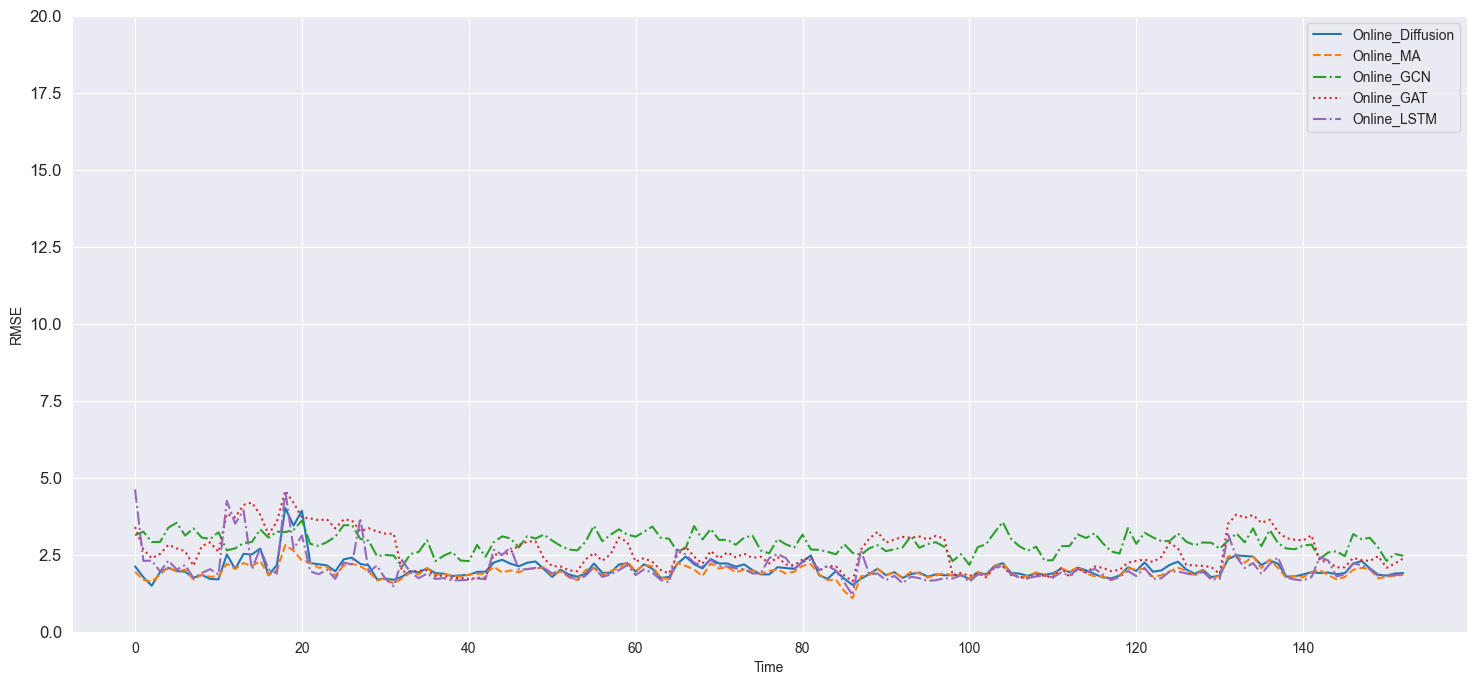

In [472]:
# x = np.arange(len(error_dict["Online_LSTM"]))
line_types = ['-', '--', '-.', ':', 'dashdot', 'dashdot', 'solid', 'dashdot']
plt.figure(figsize=(18, 8))
for i, mdl_name in enumerate(error_dict.keys()):
    sns.lineplot(x=np.arange(len(error_dict[mdl_name])), y=error_dict[mdl_name][:, 0], label=mdl_name, linestyle=line_types[i])
    plt.ylim(0, 20)
    
#adjust the size of ytiks
plt.yticks(fontsize=12)
plt.ylabel("RMSE")
plt.xlabel("Time")

In [43]:
preds["Online_Diffusion"].transpose([0, 2, 1, 3]).reshape(-1, label.shape[1], label.shape[2]).shape

(4620, 24, 6)

In [44]:
dataset_name

'train_station'

In [218]:
src, dst = g.edges()

In [45]:
for model_name in error_dict.keys():
    # pred = preds[model_name].transpose([0, 2, 1, 3]).reshape([-1, label.shape[1], label.shape[2]])
    # rmse = np.sqrt(np.mean(pred[dst, :, :] - label.numpy()[dst, :, :]) ** 2)
    # print(f"{model_name} error: {rmse}")
    # stepid = 0
    # rmse_step = np.sqrt(np.mean((pred[dst, :, stepid] - label.numpy()[dst, :, stepid]) ** 2))
    # print(f"{model_name} error: {rmse_step}")
    
    print(f"{model_name} error: {np.mean(error_dict[model_name])}")
    
    

Online_Diffusion error: 3.574310064315796
Online_MA error: 4.6397809982299805
Online_GCN error: 4.146007061004639
Online_GAT error: 4.183109760284424
Online_LSTM error: 3.3568115234375
Online_GCNLSTM error: 3.5304970741271973


In [196]:
error_dict["Online_Diffusion"].shape

(154, 6)

In [20]:
stepid = -1
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.mean(error_dict[model_name][:,stepid])}")

Online_Diffusion error: 4.1923112869262695
Online_MA error: 5.342501163482666
Online_GCN error: 5.118371963500977
Online_GAT error: 4.541139125823975
Online_LSTM error: 3.616147518157959


In [16]:
stepid = 4
for model_name in error_dict.keys():
    print(f"{model_name} error: {np.mean(error_dict[model_name][:,stepid])}")

Online_Diffusion error: 3.938019275665283
Online_MA error: 5.134544372558594
Online_GCN error: 5.0781049728393555
Online_GAT error: 4.4455413818359375
Online_LSTM error: 3.4742074012756348


## Load Output Data

In [7]:
import numpy as np
v_dict = {}
alpha_dict = {}
e_dict = {}
F_dict = {}
route_flow = {}
route_speed = {}
# dataset = "train_station"
# dataset = "crossroad"
dataset = "maze"
for m in ["Online_Diffusion", "Online_Diffusion_UQ", "Online_Diffusion_plus"]:
    try:
        error_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_curve_error_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        v_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_v_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        alpha_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_alpha_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        F_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_F_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        # route_flow[m] = np.load(f"./checkpoint/{m}_{dataset}_route_flow_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        e_dict[m] = np.load(f"./checkpoint/{m}_{dataset}_e_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.npy")
        with open(f"./checkpoint/{m}_{dataset}_route_flow_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
            route_flow[m] = pickle.load(f)   # predicted route flow
        # with open(f"./checkpoint/{m}maze2_{dataset}_route_flow_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
        #     route_flow[m] = pickle.load(f)   # predicted route flow
        with open(f"./checkpoint/{m}_{dataset}_route_speed_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
            route_speed[m] = pickle.load(f) # predicted route speed
        # with open(f"./checkpoint/{m}maze2_{dataset}_route_speed_chunk{chunk_size}_lags{lags}_hor{pred_horizon}.pkl", "rb") as f:
        #     route_speed[m] = pickle.load(f) # predicted route speed
    except:
        print(f"model_{m}, file not found")
        continue


In [8]:
route_flow["Online_Diffusion_plus"].keys()

dict_keys(['sc_sensor/maze22', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8', 'sc_sensor/maze21', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12', 'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20'])

## Speed Model Analysis

In [22]:
# plot x_up, x_down and V
src, dst = g.edges()
x_up = label[:, src, :].mean(axis=-1).transpose([1, 0])
x_down = label[:, dst, :].mean(axis=-1).transpose([1, 0])
diff = (x_up - x_down)
# mdl = "Online_Diffusion_plus"
mdl = "Online_Diffusion"
pred_speed = v_dict[mdl]
pred_diffusion = F_dict[mdl]
pred_alpha = alpha_dict[mdl]
pred_prob = e_dict[mdl]

# pred_speed = v_dict["Online_Diffusion_plus"]
# pred_diffusion = F_dict["Online_Diffusion_plus"]
# pred_alpha = alpha_dict["Online_Diffusion_plus"]
# pred_prob = e_dict["Online_Diffusion_plus"]

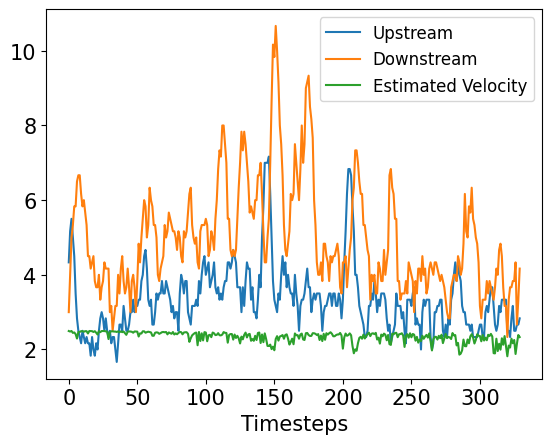

In [24]:
# according to sc_id plot the x_up and x_down and speed, using the sc_shift_signal, sc_id is the index of sc_shift_signal
import matplotlib.pyplot as plt
sc_id = 8

src_idx = 23
dst_idx = 16
# figsize
# plt.figure(figsize=(15, 5))
edge_id = np.where((src == src_idx) & (dst == dst_idx))[0][0]
# edge_id = 9
if sc_id == 0:
    start = 0
    end = sc_shift_signal[sc_id]
else:
    start = sc_shift_signal[sc_id-1]
    end = sc_shift_signal[sc_id]

plt.plot(np.arange(end - start), x_up[edge_id, start:end], label="Upstream")
plt.plot(np.arange(end - start), x_down[edge_id, start:end], label="Downstream")
plt.plot(np.arange(end - start), pred_speed[edge_id, start:end], label="Estimated Velocity")
# plt.plot(np.arange(end - start), pred_diffusion[edge_id, start:end], label="diffusion")
plt.legend(fontsize=12)
#x y ticks
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel("Timesteps", fontsize=15)
# plt.savefig(f"./fig/{dataset_name}{sc_id}_edge{src_idx}_{dst_idx}_speed_curve.pdf", bbox_inches='tight')
plt.show()

### Figure 12

/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_97897/4096021119.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_yticklabels(ax1.get_yticks(), fontsize=15)
/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_97897/4096021119.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticks().astype(int), fontsize=15)
/var/folders/cc/pdp9b2qx00dfkpyg21frcmdsjksps5/T/ipykernel_97897/4096021119.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_yticklabels([f"{x:.1f}" for x in ax2.get_yticks()], fontsize=15)


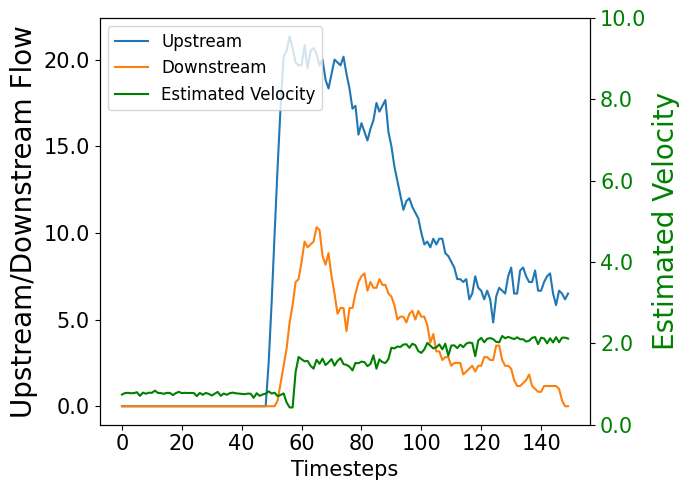

In [25]:
import numpy as np
import matplotlib.pyplot as plt

sc_id = 2
src_idx = 7
dst_idx = 11
# Assuming sc_shift_signal, x_up, x_down, pred_speed are defined

edge_id = np.where((src == src_idx) & (dst == dst_idx))[0][0]

if sc_id == 0:
    start = 0
    end = sc_shift_signal[sc_id]
else:
    start = sc_shift_signal[sc_id-1]
    end = sc_shift_signal[sc_id]

fig, ax1 = plt.subplots(figsize=(7, 5))
xaxis = np.arange(end - start).astype(int)
# Plot on primary y-axis
ax1.plot(xaxis, x_up[edge_id, start:end], label="Upstream")
ax1.plot(xaxis, x_down[edge_id, start:end], label="Downstream")
ax1.set_xlabel("Timesteps", fontsize=15)
ax1.set_ylabel("Upstream/Downstream Flow", fontsize=20)
ax1.tick_params(axis='y', labelcolor='k')
# ax1.legend(loc='upper left', fontsize=12)
ax1.set_yticklabels(ax1.get_yticks(), fontsize=15)
ax1.set_xticklabels(ax1.get_xticks().astype(int), fontsize=15)

# Create a second y-axis
ax2 = ax1.twinx()

# Plot on secondary y-axis
ax2.plot(xaxis, pred_speed[edge_id, start:end], label="Estimated Velocity", color='g')
ax2.set_ylabel("Estimated Velocity", fontsize=20, color='g')
ax2.tick_params(axis='y', labelcolor='g')
# ax2.legend(loc='upper right', fontsize=12)
# set only two decimal places for the y-axis
ax2.set_ylim(0, 10)
ax2.set_yticklabels([f"{x:.1f}" for x in ax2.get_yticks()], fontsize=15)
# ax2.set_yticklabels(ax2.get_yticks(), fontsize=15)
    # Combine legends from both y-axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=12)
fig.tight_layout()
# plt.savefig(f"./fig/{dataset_name}{sc_id}_edge{src_idx}_{dst_idx}_speed_curve.pdf", bbox_inches='tight')
plt.show()


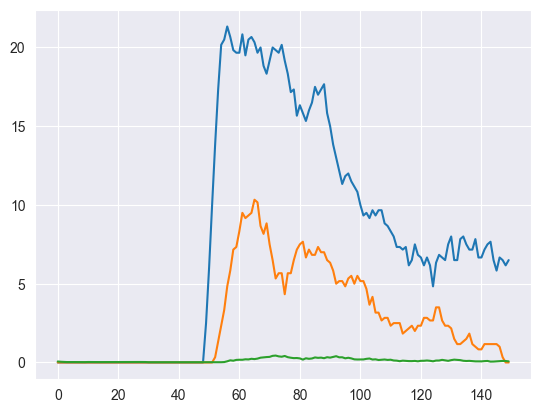

In [49]:
# plot speed
# plt.figure(figsize=(9, 8))
# plt.plot(np.arange(end - start), pred_speed[edge_id, start:end], label="Estimated Velocity")
# probability
plt.plot(np.arange(end - start), x_up[edge_id, start:end], label="Upstream")
plt.plot(np.arange(end - start), x_down[edge_id, start:end], label="Downstream")
plt.plot(np.arange(end - start), pred_prob[edge_id, start:end], label="Estimated Probability")

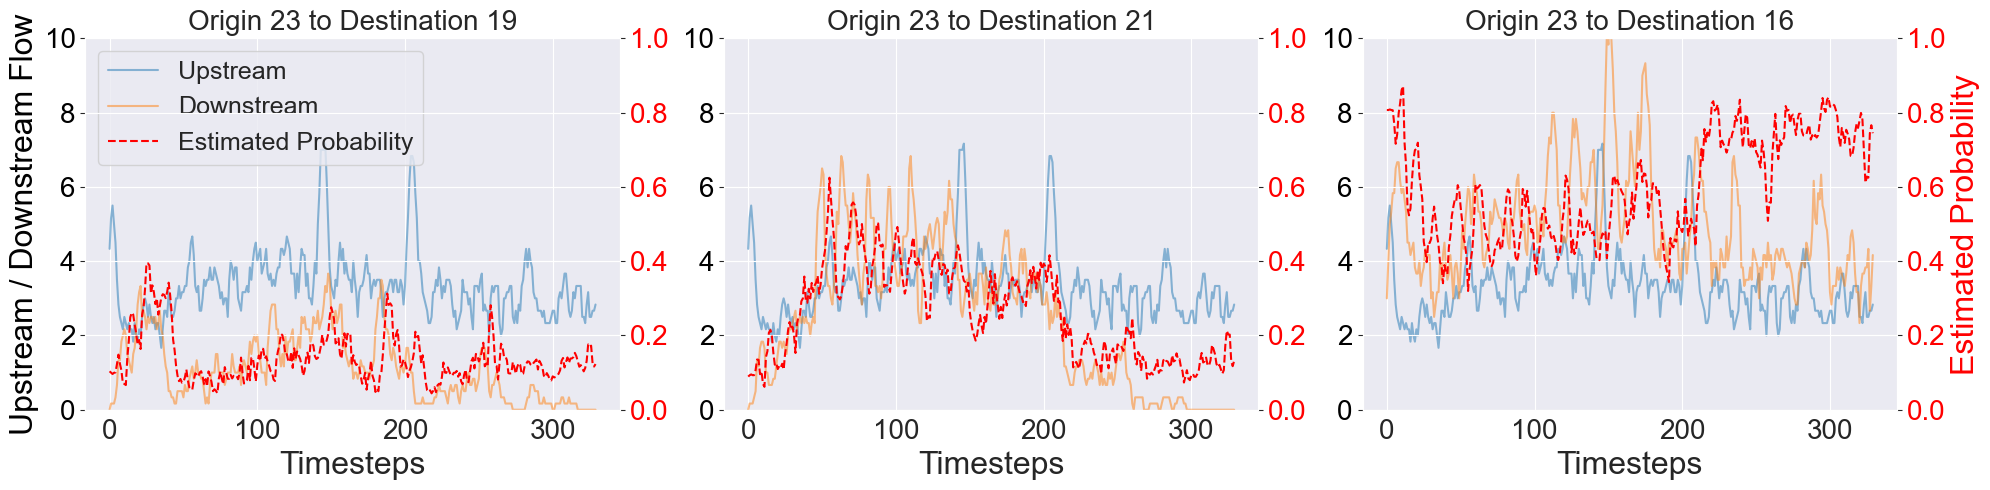

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Given variables
sc_id = 8
src_idx = 23
dst_indices = [19, 21, 16]  # List of destination indices
# Assuming sc_shift_signal, x_up, x_down, pred_speed are defined
if sc_id == 0:
    start = 0
    end = sc_shift_signal[sc_id]
else:
    start = sc_shift_signal[sc_id-1]
    end = sc_shift_signal[sc_id]


fig, axs = plt.subplots(1, 3, figsize=(20, 5))  # Create 3 subplots in a column

for i, dst_idx in enumerate(dst_indices):
    edge_id = np.where((src == src_idx) & (dst == dst_idx))[0][0]
    ax1 = axs[i]
    
    # Plot the Upstream and Downstream data on the primary y-axis
    ax1.plot(np.arange(end - start), x_up[edge_id, start:end], label="Upstream", alpha=0.5)
    ax1.plot(np.arange(end - start), x_down[edge_id, start:end], label="Downstream", alpha=0.5)
    
    ax1.set_xlabel('Timesteps', fontsize=23)
    if i == 0:
        ax1.set_ylabel('Upstream / Downstream Flow', color='black', fontsize=23)
    ax1.set_ylim(0, 10)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)
    
    # Create a second y-axis for the predicted probability
    ax2 = ax1.twinx()
    ax2.plot(np.arange(end - start), pred_prob[edge_id, start:end], label="Estimated Probability", color='red', linestyle='--')
    if i == 2:
        ax2.set_ylabel('Estimated Probability', color='red', fontsize=23)
    ax2.tick_params(axis='y', labelcolor='red', labelsize=20)
    ax2.set_ylim(0, 1)
    
    # Combine legends from both y-axes
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    if i == 0:
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=18)
    
    ax1.set_title(f"Origin {src_idx} to Destination {dst_idx}", fontsize=20)

plt.tight_layout()
# save pdf
# plt.savefig(f"./fig/{dataset_name}_sc{sc_id}_edge{src_idx}_prob_curve.pdf", bbox_inches='tight')
plt.show()


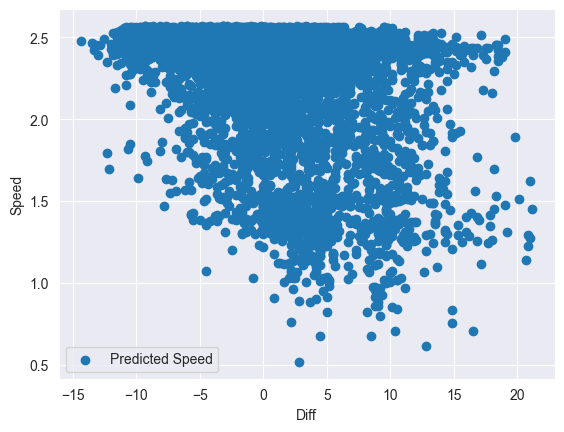

In [51]:
# plt.plot(time, diff[edge_id, :, :].numpy().mean(axis=-1).squeeze(), label=f"Upstream - Downstream Flow")
x = diff[:, start:end].squeeze()
plt.scatter(x, pred_speed[:, start:end].squeeze(), label=f"Predicted Speed")
plt.xlabel('Diff')
plt.ylabel('Speed')
plt.legend()

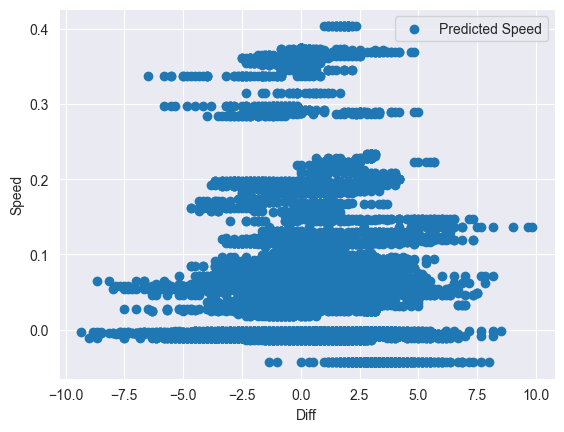

In [217]:
# plot F
plt.scatter(x, pred_alpha[:, start:end].squeeze(), label=f"Predicted Speed")
plt.xlabel('Diff')
plt.ylabel('Speed')
plt.legend()

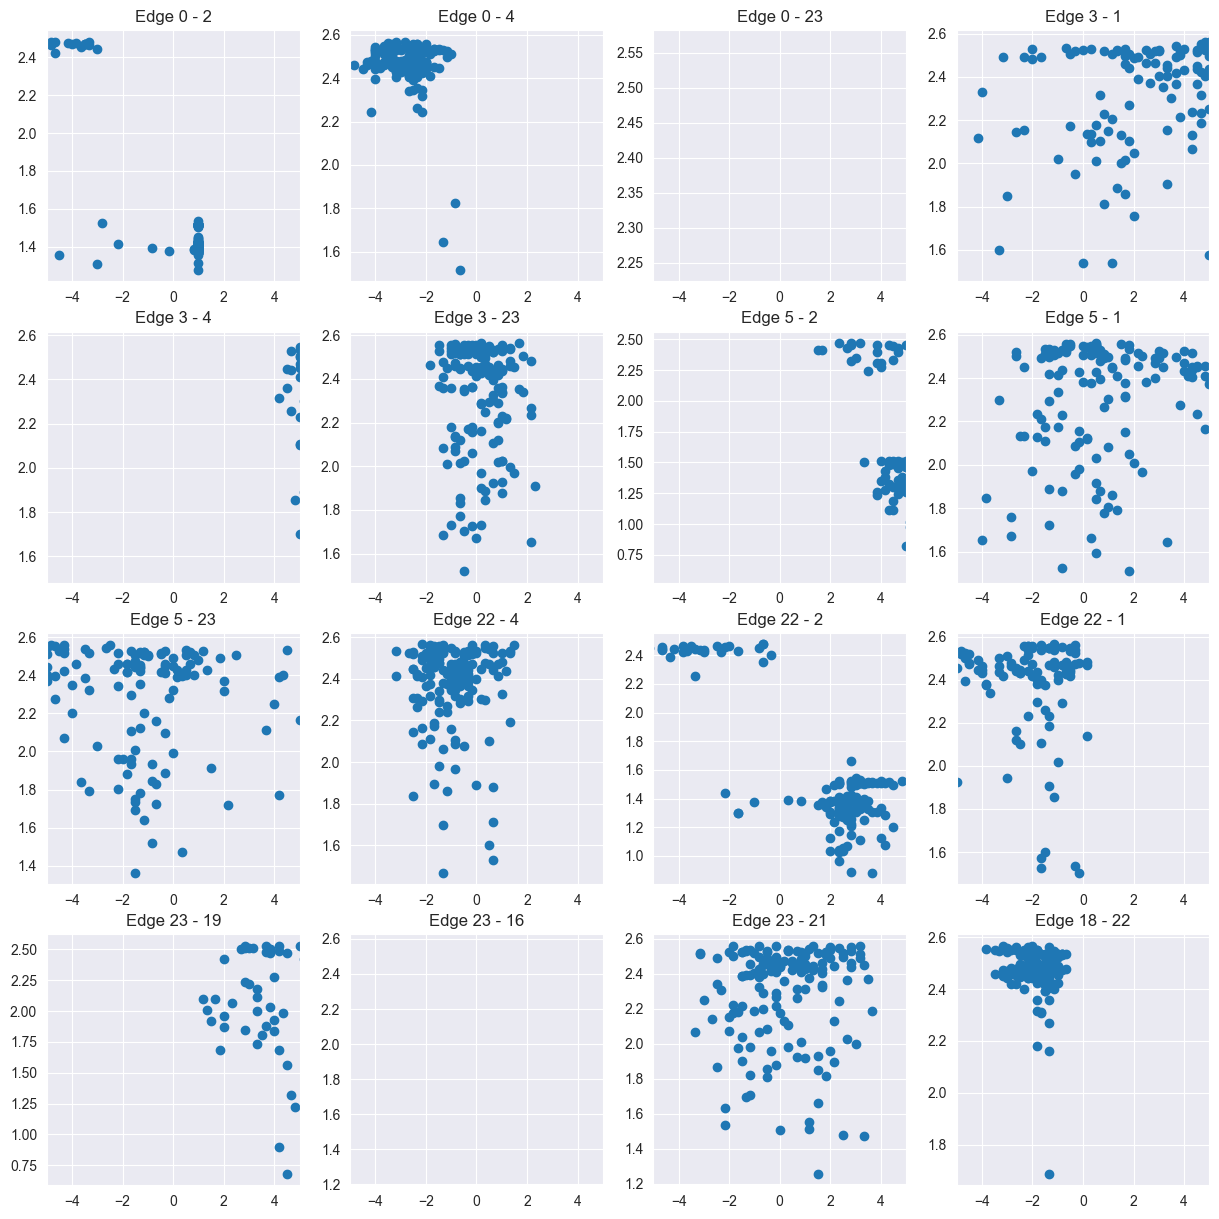

In [52]:
subplot_length = 4
fig, axs = plt.subplots(subplot_length, subplot_length, figsize=(15, 15))
time = np.arange(x_up.shape[1])
diff = (x_up - x_down)
for i in range(subplot_length**2):
    edge_id = i
    # diff = x_up[edge_id, :, :].numpy().mean(axis=-1).squeeze() - x_down[edge_id, :, :].mean(axis=-1).squeeze()
    # axs[i//subplot_length, i%subplot_length].set_xlim(-20, 20) # train_station
    axs[i//subplot_length, i%subplot_length].set_xlim(-5, 5) # maze
    axs[i//subplot_length, i%subplot_length].scatter(diff[edge_id, start:end], pred_speed[edge_id, start:end].squeeze())
    # axs[i//subplot_length, i%subplot_length].scatter(diff[edge_id, start:end], pred_diffusion[edge_id, start:end].squeeze())
    # ylim
    axs[i//subplot_length, i%subplot_length].set_title(f"Edge {src[i]} - {dst[i]}")

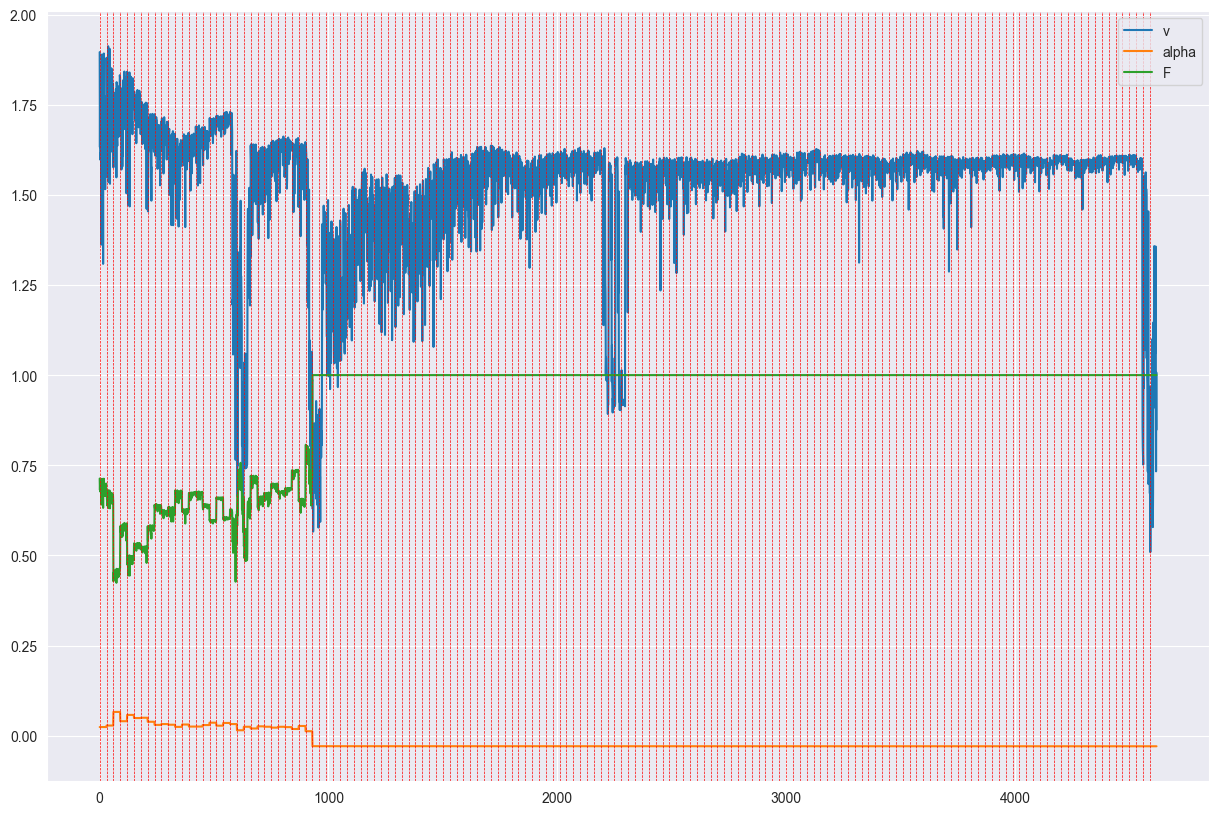

In [29]:
import matplotlib.pyplot as plt
# get the edge id by src and dst
src = 0
dst = 12
edge_id = g.edge_ids(src, dst)
# try:
#     v = torch.cat(v, dim=1).detach().numpy()
#     alpha = torch.cat(alpha, dim=1).detach().numpy()
# except:
#     pass
# mdl = "Online_Diffusion_UQ"
mdl = "Online_Diffusion"
# mdl = "Online_Diffusion_plus"
v = v_dict[mdl]
alpha = alpha_dict[mdl]
F = F_dict[mdl]
# branch_flow = route_flow["Online_Diffusion"]
# branch_flow = branch_flow.transpose([2, 0, 1]).reshape(branch_flow.shape[1], -1)
# edge_id = g.edge_ids(
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
plt.plot(np.arange(F.shape[1]), F[edge_id, :], label="F")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

In [88]:
import pickle
# with open("../nomad/examples/branch_flow_data.pkl", "rb") as f: # not complete version
#     all_scenarios = pickle.load(f)
with open("../nomad/examples/od_data.pkl", "rb") as f: # complete version
    all_scenarios = pickle.load(f)
    
act_list = ["waypoint8", "waypoint3", "waypoint6", "waypoint7", "exit1",
            "exit2", "exit3", "exit4", "exit5", "exit6", "exit7", "exit8"]

gt_flow = all_scenarios["sc_sensor/maze18"]
concat_data = []
for k in all_scenarios.keys():
    concat_data.append(all_scenarios[k])
concat_data = np.concatenate(concat_data, axis=0)
point_to_node = {"waypoint8": [22, 23], "waypoint3": [4, 5], "waypoint6": [16, 17], "waypoint7": [11, 10],
                 "exit1": [21, 20], "exit2": [14, 15], "exit3": [12, 13], "exit4": [8, 9], "exit5": [6,7],
                 "exit6": [2,3], "exit7": [0,1], "exit8": [18,19]}
node_to_point = {22: "waypoint8", 23: "waypoint8", 4: "waypoint3", 5: "waypoint3", 16: "waypoint6", 17: "waypoint6",
                    11: "waypoint7", 10: "waypoint7", 21: "exit1", 20: "exit1", 14: "exit2", 15: "exit2", 12: "exit3",
                    13: "exit3", 8: "exit4", 9: "exit4", 6: "exit5", 7: "exit5", 2: "exit6", 3: "exit6", 0: "exit7",
                    1: "exit7", 18: "exit8", 19: "exit8"}   


In [89]:
# Online Diffusion UQ
# src = 7
# dst = 2
v = v_dict["Online_Diffusion_UQ"]
alpha = alpha_dict["Online_Diffusion_UQ"]
F = F_dict["Online_Diffusion_UQ"]
branch_flow = route_flow["Online_Diffusion_UQ"]
branch_flow = branch_flow.transpose([2, 0, 1]).reshape(branch_flow.shape[1], -1)
edge_id = g.edge_ids(src, dst)
plt.figure(figsize=(15, 10))
plt.plot(np.arange(v.shape[1]), v[edge_id, :], label="v")
plt.plot(np.arange(alpha.shape[1]), alpha[edge_id, :], label="alpha")
# every 10 steps plot a vertical line
for i in range(0, v.shape[1], chunk_size):
    plt.axvline(x=i, color='r', linestyle='--', linewidth=0.5)
plt.legend()

AttributeError: 'dict' object has no attribute 'transpose'

In [56]:
data_dict["sc_sensor/maze22"].shape

(360, 24)

## Compare OD Matrix

In [90]:
# alpha = alpha_dict["diffusion"]
# alpha = alpha_dict["Online_Diffusion"]
# alpha = e_dict["Online_Diffusion"]
# mdl = "Online_Diffusion_UQ"
# mdl = "Online_Diffusion"
# mdl = "Online_Diffusion_plus"
edge_flows = route_flow[mdl]

In [91]:
edge_flows["sc_sensor/maze22"].shape

(48, 330)

In [92]:
# Estimated edge flows matrix
num_nodes = g.number_of_nodes()
src, dst = g.edges()
sc = "sc_sensor/maze22"

num_edges = len(src)
sample_size = edge_flows[sc].shape[1]  # time length
flow_mat = np.zeros((num_nodes, num_nodes, sample_size))
for i in range(num_edges):
    flow_mat[src[i], dst[i], :] = edge_flows[sc][i, :]

<Axes: >

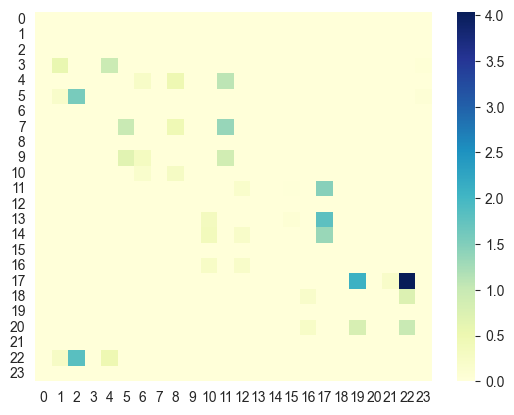

In [93]:
import seaborn as sns
sns.heatmap(flow_mat[..., -1], cmap="YlGnBu")

In [94]:
# visualize attention matrix
# import seaborn as sns
# sns.heatmap(atten_mat[..., -1], cmap="YlGnBu")

In [95]:
# Estimated OD matrix, continue from last cell
od_mat = np.zeros([len(point_to_node), len(point_to_node), flow_mat.shape[-1]])
# translate atten_mat to od_mat:
for n in range(flow_mat.shape[-1]):
    for i in range(flow_mat.shape[0]):
        if np.sum(flow_mat[i, :]) == 0:
            continue
        for j in range(flow_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if flow_mat[i, j, n] != 0:
                od_mat[src_idx, dst_idx, n] = flow_mat[i, j, n]

In [96]:
sc

'sc_sensor/maze22'

In [97]:
# ground truth
gt_flow = all_scenarios[sc]

In [98]:
od_mat.shape, gt_flow.shape

((12, 12, 330), (360, 12, 12))

<Figure size 2000x700 with 0 Axes>

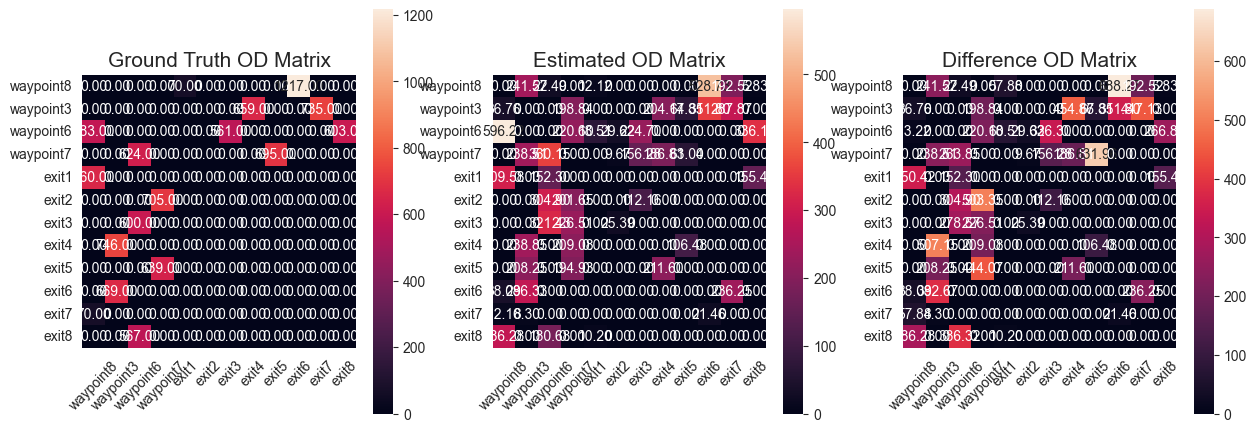

In [99]:
import seaborn as sns
plt.figure(figsize=(20, 7))
# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 3, figsize=(15, 7))
# normalize by row
#sum of col
sum_of_row = gt_flow[:-chunk_size, ...].sum(axis=0).sum(axis=0)
# A = gt_flow[:-chunk_size, ...].sum(axis=0)/sum_of_row
A = gt_flow[:-chunk_size, ...].sum(axis=0)
# Plot ground truth flow mat, sum over time in one scenario
sns.heatmap(A, annot=True, fmt=".2f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[0], square=True, cbar_kws={"shrink": 0.75})
axs[0].set_title('Ground Truth OD Matrix', fontsize=15)
axs[0].tick_params(axis='x', rotation=45)
# Plot predicted flow mat
sum_of_row = od_mat.sum(axis=-1).sum(axis=0)
# B = od_mat.sum(axis=-1)/sum_of_row
B = od_mat.sum(axis=-1)
sns.heatmap(B, annot=True, fmt=".2f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[1], square=True, cbar_kws={"shrink": 0.75})
axs[1].set_title('Estimated OD Matrix', fontsize=15)
axs[1].tick_params(axis='x', rotation=45)

# difference between ground truth and predicted
C = np.abs(A - B)
sns.heatmap(C, annot=True, fmt=".2f", xticklabels=act_list,
            yticklabels=act_list, square=True, cbar_kws={"shrink": 0.75})
axs[2].set_title('Difference OD Matrix', fontsize=15)
axs[2].tick_params(axis='x', rotation=45)

# Display the figure
plt.show()

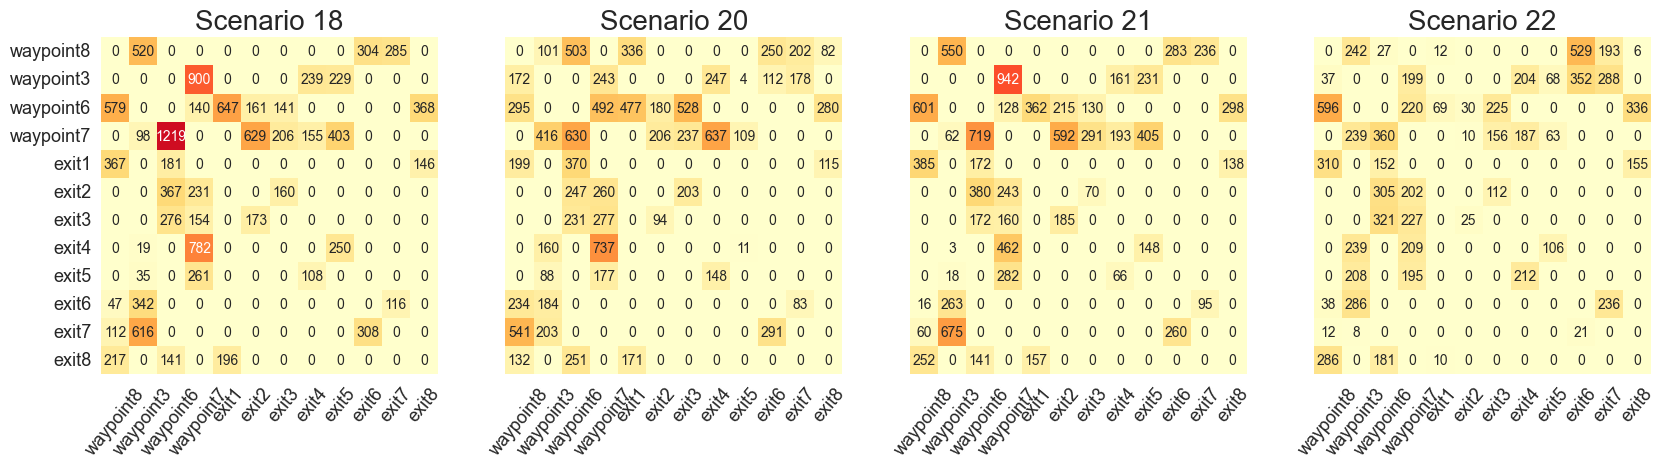

In [100]:
# visualize the change of the od matrix as the scenario changes
# sc_list = ['sc_sensor/maze8', 'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18']
# sc_list = ['sc_sensor/maze14', 'sc_sensor/maze18', 'sc_sensor/maze2', 'sc_sensor/maze20']
sc_list = ['sc_sensor/maze18', 'sc_sensor/maze20', 'sc_sensor/maze21', 'sc_sensor/maze22']
pred_flow_mat = []

# sc_list = ['sc_sensor/train2', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train10']
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc_num, sc in enumerate(sc_list):
    # num_edges = len(src)
    sample_size = edge_flows[sc].shape[1]  # time length
    flow_mat = np.zeros((num_nodes, num_nodes, sample_size))
    for i in range(num_edges):
        flow_mat[src[i], dst[i], :] = edge_flows[sc][i, :]
    od_mat = np.zeros([len(point_to_node), len(point_to_node), flow_mat.shape[-1]])
    for n in range(flow_mat.shape[-1]):
        for i in range(flow_mat.shape[0]):
            if np.sum(flow_mat[i, :]) == 0:
                continue
            for j in range(flow_mat.shape[1]):
                src_node = node_to_point[i]  # waypoint
                dst_node = node_to_point[j]
                src_idx = act_list.index(src_node)
                dst_idx = act_list.index(dst_node)
                if flow_mat[i, j, n] != 0:
                    od_mat[src_idx, dst_idx, n] = flow_mat[i, j, n]
    if sc_num == 0:
        sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f",
                     ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list)
        # sns.heatmap(od_mat.sum(axis=-1)/(od_mat.sum(axis=-1).sum(axis=1,keepdims=True)), annot=True, fmt=".1f",
        #      ax=axs[sc_num], square=True, cbar=False, vmax=1, cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list)
    else:
        sns.heatmap(od_mat.sum(axis=-1), annot=True, fmt=".0f", xticklabels=act_list,
                    yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
        # sns.heatmap(od_mat.sum(axis=-1)/(od_mat.sum(axis=-1).sum(axis=1, keepdims=True)), annot=True, fmt=".1f", xticklabels=act_list,
        #             yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1, cmap="YlOrRd")

    pred_flow_mat.append(od_mat.sum(axis=-1))    
    axs[sc_num].set_title(f'Scenario {sc.split("maze")[-1]}', fontsize=20)
    axs[sc_num].tick_params(axis='x', rotation=50, labelsize=13)
    axs[sc_num].tick_params(axis='y', labelsize=13)
# plt.savefig(f"./fig/{dataset_name}_pred_od_matrix.pdf", bbox_inches='tight')
# plt.savefig(f"./fig/{dataset_name}_pred_od_matrix_percentage.pdf", bbox_inches='tight')

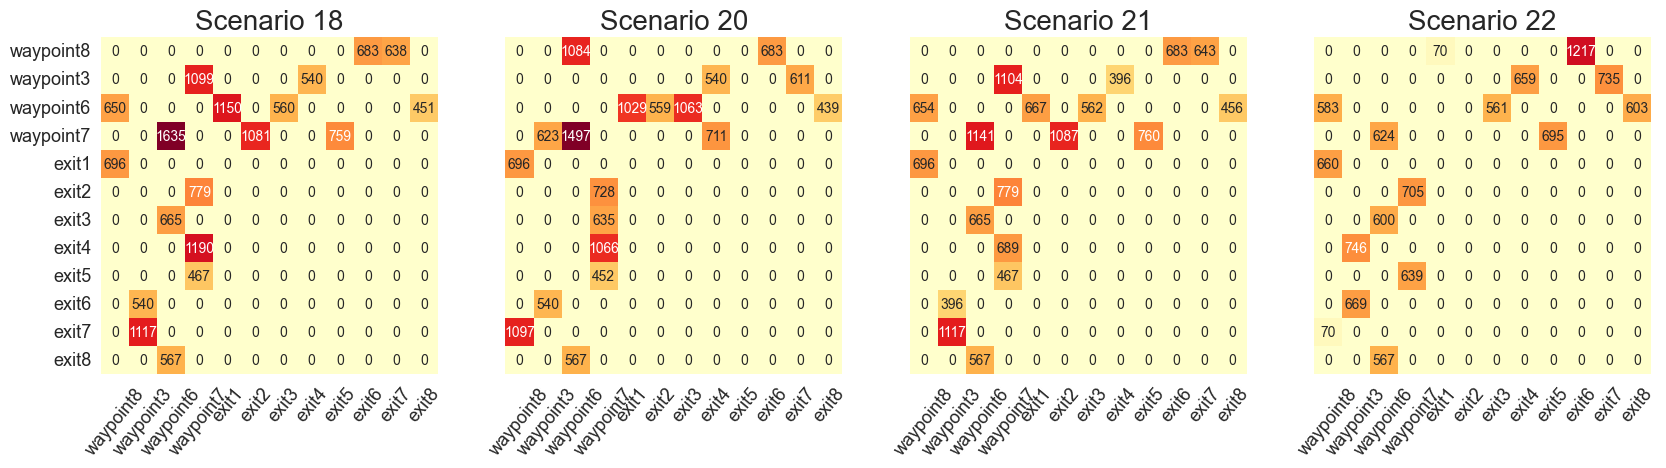

In [101]:
# visualize the ground truth od matrix
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
gt_mat_list = []
for sc_num, sc in enumerate(sc_list):
    gt_flow = all_scenarios[sc][:-chunk_size,...] # same size as the predicted flow
    # adjust the scale of the color
    
    if sc_num == 0:
        sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f"
                    , ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list)
        # sns.heatmap(gt_flow.sum(axis=0)/(gt_flow.sum(axis=0).sum(axis=1, keepdims=True)+1e-5), annot=True, fmt=".1f"
        #             , ax=axs[sc_num], square=True, cbar=False, vmax=1, cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list)
    else:
        sns.heatmap(gt_flow.sum(axis=0), annot=True, fmt=".0f", xticklabels=act_list,
                    yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
        # sns.heatmap(gt_flow.sum(axis=0)/(gt_flow.sum(axis=0).sum(axis=1, keepdims=True)+1e-10), annot=True, fmt=".1f", xticklabels=act_list,
        #             yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1, cmap="YlOrRd")
    
    gt_mat_list.append(gt_flow.sum(axis=0))
    axs[sc_num].set_title(f'Scenario {sc.split("maze")[-1]}', fontsize=20)
    axs[sc_num].tick_params(axis='x', rotation=50, labelsize=13)
    axs[sc_num].tick_params(axis='y', labelsize=13)
# plt.savefig(f"./fig/{dataset_name}_gt_od_matrix.pdf", bbox_inches='tight')
# plt.savefig(f"./fig/{dataset_name}_gt_od_matrix_percentage.pdf", bbox_inches='tight')

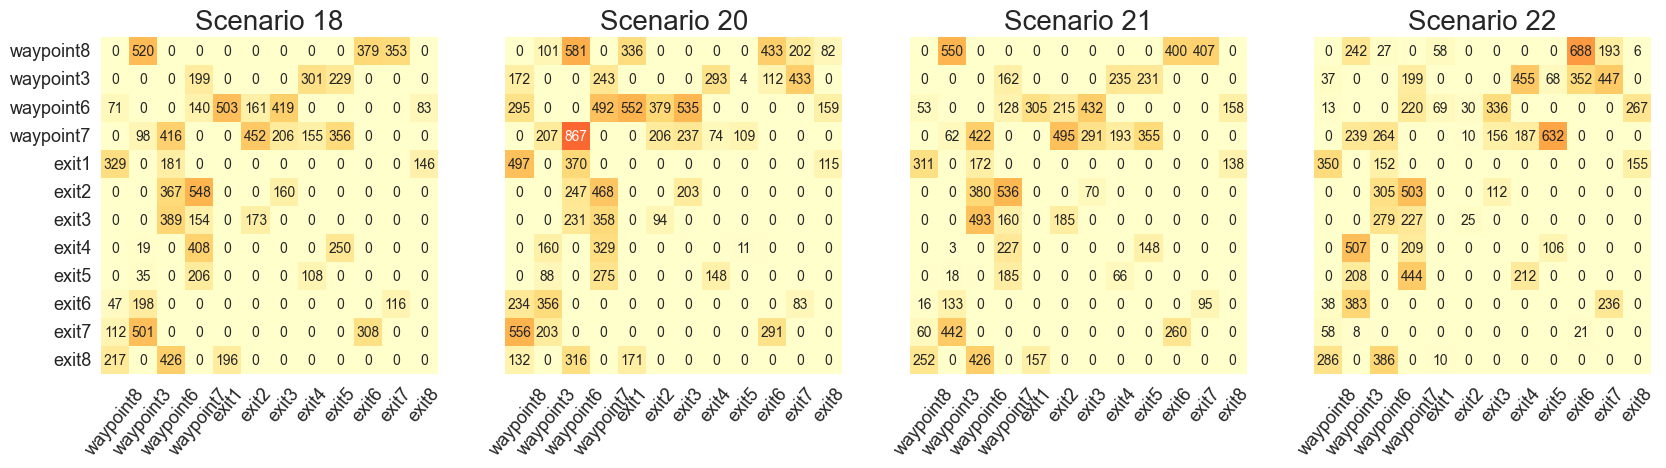

In [102]:
# visualize the difference between ground truth and predicted od matrix
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc_num, sc in enumerate(sc_list):
    diff_mat = np.abs(gt_mat_list[sc_num] - pred_flow_mat[sc_num])
    if sc_num == 0:
        sns.heatmap(diff_mat, annot=True, fmt=".0f"
                    , ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list)
    else:
        sns.heatmap(diff_mat, annot=True, fmt=".0f", xticklabels=act_list,
                    yticklabels=False, ax=axs[sc_num], square=True, cbar=False, vmax=1500, cmap="YlOrRd")
    axs[sc_num].set_title(f'Scenario {sc.split("maze")[-1]}', fontsize=20)
    axs[sc_num].tick_params(axis='x', rotation=50, labelsize=13)
    axs[sc_num].tick_params(axis='y', labelsize=13)
    
    

## Comare FD

In [27]:
edge_speeds = route_speed[mdl]
edge_flows = route_flow[mdl]
edge_speeds.keys()

dict_keys(['sc_sensor/maze22', 'sc_sensor/maze2', 'sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8', 'sc_sensor/maze21', 'sc_sensor/maze16', 'sc_sensor/maze15', 'sc_sensor/maze19', 'sc_sensor/maze12', 'sc_sensor/maze8_2', 'sc_sensor/maze10_2', 'sc_sensor/maze18', 'sc_sensor/maze13', 'sc_sensor/maze20'])

In [31]:
import matplotlib.pyplot as plt
sc = "sc_sensor/train10"
pred_speed = edge_speeds[sc]
pred_flow = edge_flows[sc]
edge_id = np.where((src == 23) & (dst == 13))[0][0]
plt.scatter(pred_flow[edge_id, :].reshape(-1), pred_speed[edge_id, :].reshape(-1), marker='>')

KeyError: 'sc_sensor/train10'

### Appendix FD

In [28]:
# concate the speed and flow of each scenario
speed_list = []
flow_list = []
for i, sc in enumerate(edge_speeds.keys()):
    # if i == 1:
    #     break
    speed_list.append(edge_speeds[sc])
    flow_list.append(edge_flows[sc])
speed_list = np.concatenate(speed_list, axis=1)
flow_list = np.concatenate(flow_list, axis=1)
speed_list.shape, flow_list.shape

((48, 4590), (48, 4590))

IndexError: index 0 is out of bounds for axis 0 with size 0

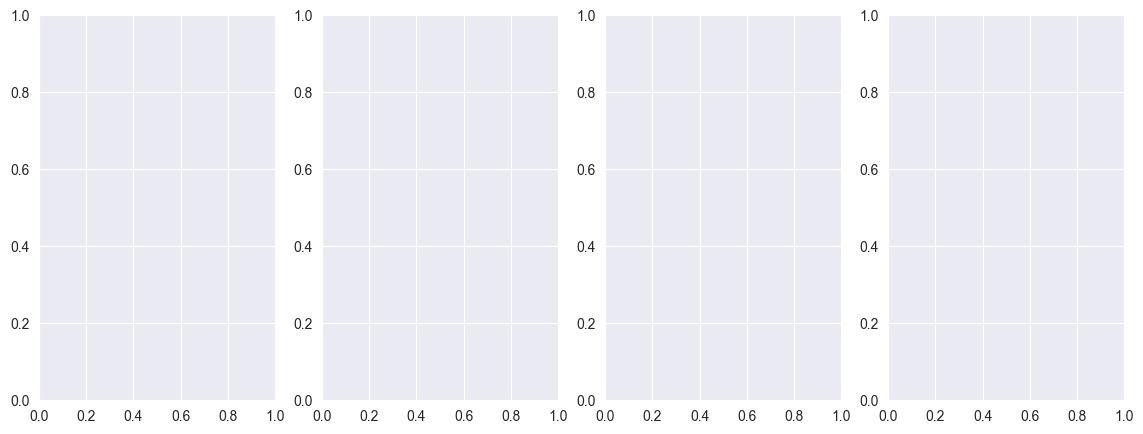

In [104]:
# multiple locations
source = [23, 23, 3, 22]
dest = [13, 10, 23, 2]
titles = ["Main Hall", "Escalator", "Gateway", "Exit"]

fig, axs = plt.subplots(1, 4, figsize=(14, 5))
for i in range(4):
    edge_id = np.where((src == source[i]) & (dst == dest[i]))[0][0]
    axs[i].scatter(flow_list[edge_id, :].reshape(-1), speed_list[edge_id, :].reshape(-1), marker='>')
    axs[i].set_xlim(0, 30)
    axs[i].set_ylim(0, 3)
    # axs[i].set_xlabel("Predicted Route Flow", fontsize=15)
    axs[0].set_ylabel("Predicted Route Velocity", fontsize=18)
    axs[i].set_title(titles[i], fontsize=18)
    
    # Ticks
    axs[i].tick_params(axis='x', labelsize=15)
    axs[i].tick_params(axis='y', labelsize=15)

# Add a main x-label for the entire figure
fig.text(0.5, 0, 'Predicted Route Flow', ha='center', fontsize=18)

plt.tight_layout()
plt.subplots_adjust(bottom=0.15)  # Adjust bottom to make space for the main x-label
# plt.show()
# plt.savefig(f"./fig/{dataset_name}_speed_flow_differentloc.pdf", bbox_inches='tight')

### Load FD Data (Maze) for figure 11

In [31]:
with open("../nomad/examples/fd_data.pkl", "rb") as f:
    fd_all_scenarios = pickle.load(f)
with open("../nomad/examples/new_fd_data.pkl", "rb") as f:
    new_fd_data = pickle.load(f)

## Analyze F and Alpha with GT Flow

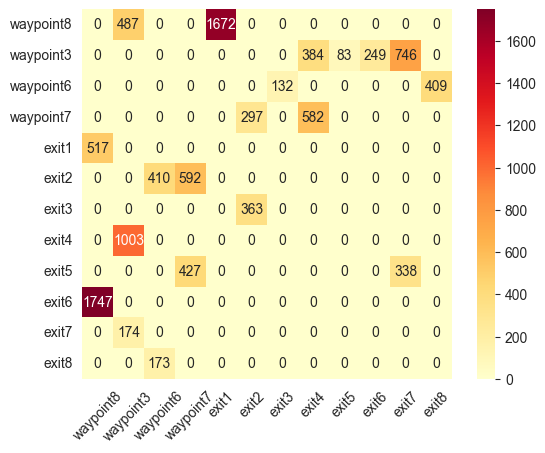

In [106]:
sc = "sc_sensor/maze3"
gt_od = all_scenarios[sc] # sparse
# gt_od = fd_all_scenarios[sc]
ax = sns.heatmap(gt_od.sum(axis=0), annot=True, fmt=".0f", cmap="YlOrRd", xticklabels=act_list, yticklabels=act_list,
                    square=True)
ax.tick_params(axis='x', rotation=45)
plt.show()

In [107]:
# ground truth route flow vs F and alpha
right = sc_shift_signal[test_sc.index(sc)]
if test_sc.index(sc) == 0:
    left = 0
else:
    left = sc_shift_signal[test_sc.index(sc)-1]
scenario_F = F_dict["Online_Diffusion"][:, left:right]
scenario_alpha = alpha_dict["Online_Diffusion"][:, left:right]
sc_label = label[left:right, :, 0]
sc_pred = preds["Online_Diffusion"].transpose([0, 2, 1, 3]).reshape(-1, preds["Online_Diffusion"].shape[1], preds["Online_Diffusion"].shape[3])[left:right, :, 0]
scenario_flow = new_fd_data[sc]["flow"][:scenario_F.shape[1], :, :].transpose([1, 2, 0])
left, right

(480, 630)

In [108]:
new_fd_data[sc]["flow"].shape

(180, 12, 12)

In [109]:
# predicted edge diffusions
scenario_F.shape, scenario_flow.shape    

((48, 150), (12, 12, 150))

In [110]:
# Continue from last cell
sample_size = scenario_F.shape[1]
F_mat = np.zeros((num_nodes, num_nodes, sample_size))
alpha_mat = np.zeros((num_nodes, num_nodes, sample_size))
for i in range(num_edges):
    F_mat[src[i], dst[i], :] = scenario_F[i, :]
    alpha_mat[src[i], dst[i], :] = scenario_alpha[i, :]

In [111]:
# translate F_mat to F_od_mat
F_od_mat = np.zeros([len(point_to_node), len(point_to_node), sample_size])
alpha_od_mat = np.zeros([len(point_to_node), len(point_to_node), sample_size])
for n in range(sample_size):
    for i in range(F_mat.shape[0]):
        if np.sum(flow_mat[i, :]) == 0: # no flow
            continue
        for j in range(F_mat.shape[1]):
            src_node = node_to_point[i]  # waypoint
            dst_node = node_to_point[j]
            src_idx = act_list.index(src_node)
            dst_idx = act_list.index(dst_node)
            if flow_mat[i, j, n] != 0:  # use flow mat here
                F_od_mat[src_idx, dst_idx, n] = F_mat[i, j, n]
                alpha_od_mat[src_idx, dst_idx, n] = alpha_mat[i, j, n]



In [112]:
F_od_mat.shape

(12, 12, 150)

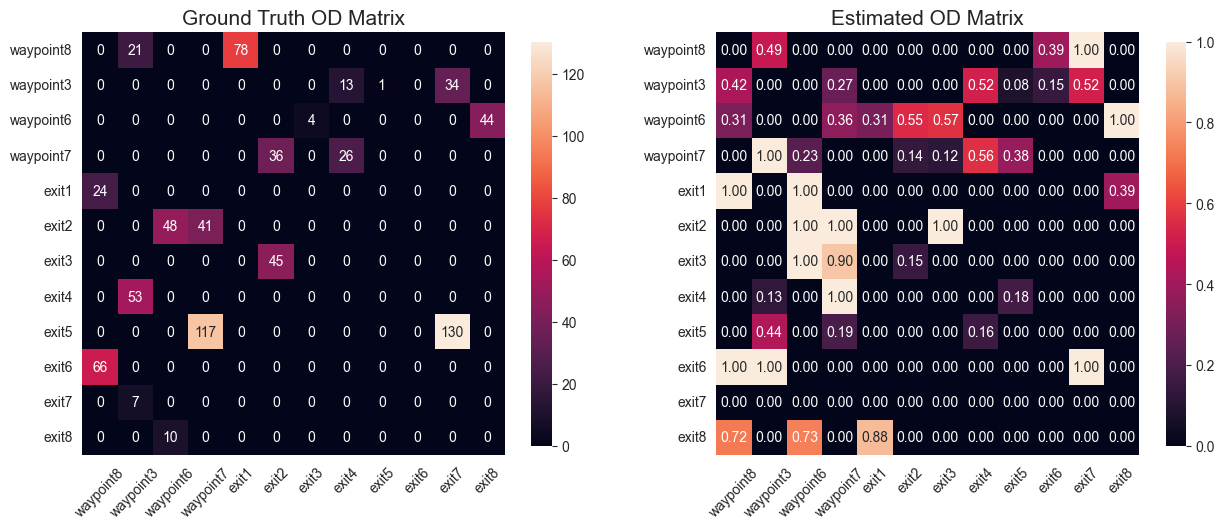

In [113]:
# visualize F_od_mat and scenario_flow
fig, axs = plt.subplots(1, 2, figsize=(15, 7))
# Plot ground truth flow mat, sum over time in one scenario
timestep = 100
timestep2 = timestep + 10
sns.heatmap(scenario_flow[..., timestep:timestep2].mean(-1), annot=True, fmt=".0f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[0], square=True, cbar_kws={"shrink": 0.75})
axs[0].set_title('Ground Truth OD Matrix', fontsize=15)
axs[0].tick_params(axis='x', rotation=45)
# Plot predicted flow mat
sns.heatmap(F_od_mat[..., timestep:timestep2].mean(-1), annot=True, fmt=".2f", xticklabels=act_list,
            yticklabels=act_list, ax=axs[1], square=True, cbar_kws={"shrink": 0.75})
axs[1].set_title('Estimated OD Matrix', fontsize=15)
axs[1].tick_params(axis='x', rotation=45)
    

In [80]:
# plot relationship between F and GT flow
# import matplotlib.pyplot as plt
# import seaborn as sns
# plt.figure(figsize=(8, 5))
# plt.scatter(scenario_flow.reshape(-1), F_od_mat.reshape(-1), marker='o')
# plt.xlabel("GT Flow")
# plt.ylabel("F")

Text(0.5, 1.0, 'GT Flow exit6 to waypoint3, scsc_sensor/maze3')

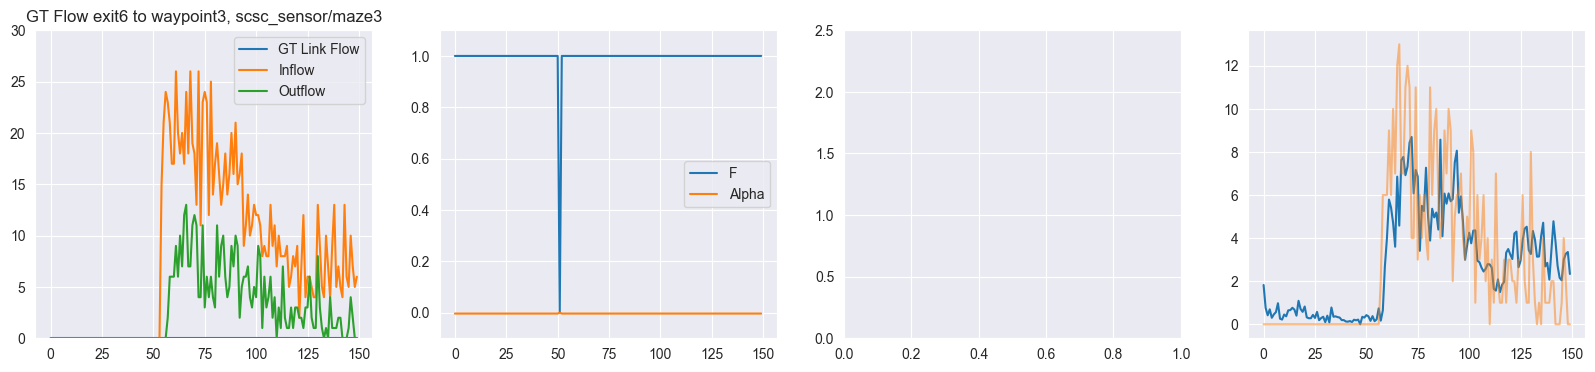

In [114]:
# plot it as time change, use subplot
fig, axs = plt.subplots(1, 4, figsize=(20, 4))
# origin = "exit2"
origin = "exit6"
# origin = "waypoint7"
# destination = "exit7"
destination = "waypoint3"
origin2 = "exit6"
destination2 = "waypoint3"
up_id = 7
down_id = 11
edge_id = np.where((src == up_id) & (dst == down_id))[0][0]
row = act_list.index(origin)
col = act_list.index(destination)
row2 = act_list.index(origin2)
col2 = act_list.index(destination2)
flow = scenario_flow[row, col, :]
pred_f = F_od_mat[row2, col2, :]
pred_alpha = alpha_od_mat[row, col, :]
p_speed = pred_speed[edge_id, :]
axs[0].plot(flow, label="GT Link Flow")
axs[0].plot(sc_label[:, up_id], label="Inflow")
axs[0].plot(sc_label[:, down_id], label="Outflow")
axs[1].plot(pred_f, label="F")
axs[1].plot(pred_alpha, label="Alpha")

# axs[2].plot(p_speed, label="Speed")
# 
# 
axs[3].plot(sc_pred[:, down_id], label="Predicted Outflow")
axs[3].plot(sc_label[:, down_id], label="GT Outflow", alpha=0.5)


axs[0].set_ylim(0, 30)
axs[1].set_ylim(-0.1, 1.1)
axs[2].set_ylim(0, 2.5)
axs[0].legend()
axs[1].legend()
# axs[2].legend()
# axs[3].legend()
# set title for the plot
axs[0].set_title(f"GT Flow {origin} to {destination}, sc{sc}")



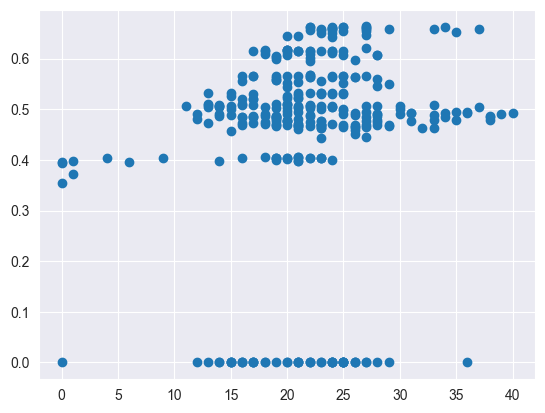

In [178]:
plt.scatter(flow, pred_f, marker='o')

## Visualize FD

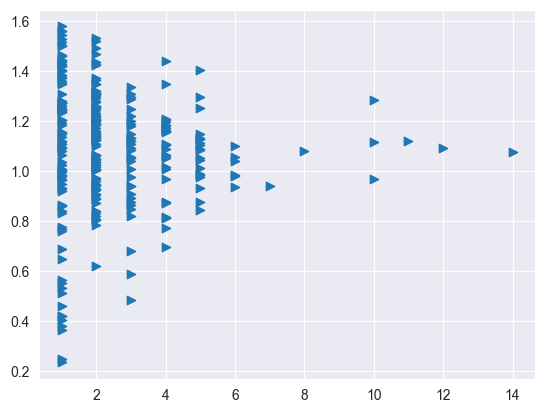

In [51]:
fd = fd_all_scenarios[sc]
OD_names = 'waypoint6|waypoint8'
sub_df = fd[fd.index.get_level_values("OD")==OD_names]
# sub_df = fd
flow = sub_df["f"].values
speed = sub_df["s"].values
plt.scatter(flow, speed, marker='>')
plt.show()

In [297]:
sub_df["flow"][:, row, col].shape

(360,)

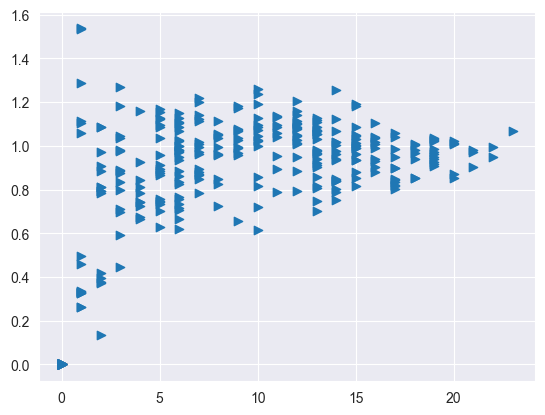

In [52]:
new_fd = new_fd_data[sc]
OD_names = 'waypoint6|waypoint8'
# sub_df = fd[fd.index.get_level_values("OD")==OD_names]
sub_df = new_fd
flow = sub_df["flow"][:, row, col].reshape(-1)
speed = sub_df["speed"][:, row, col].reshape(-1)
# flow = sub_df["flow"].reshape(-1)
# speed = sub_df["speed"].reshape(-1)
plt.scatter(flow, speed, marker='>')
plt.show()


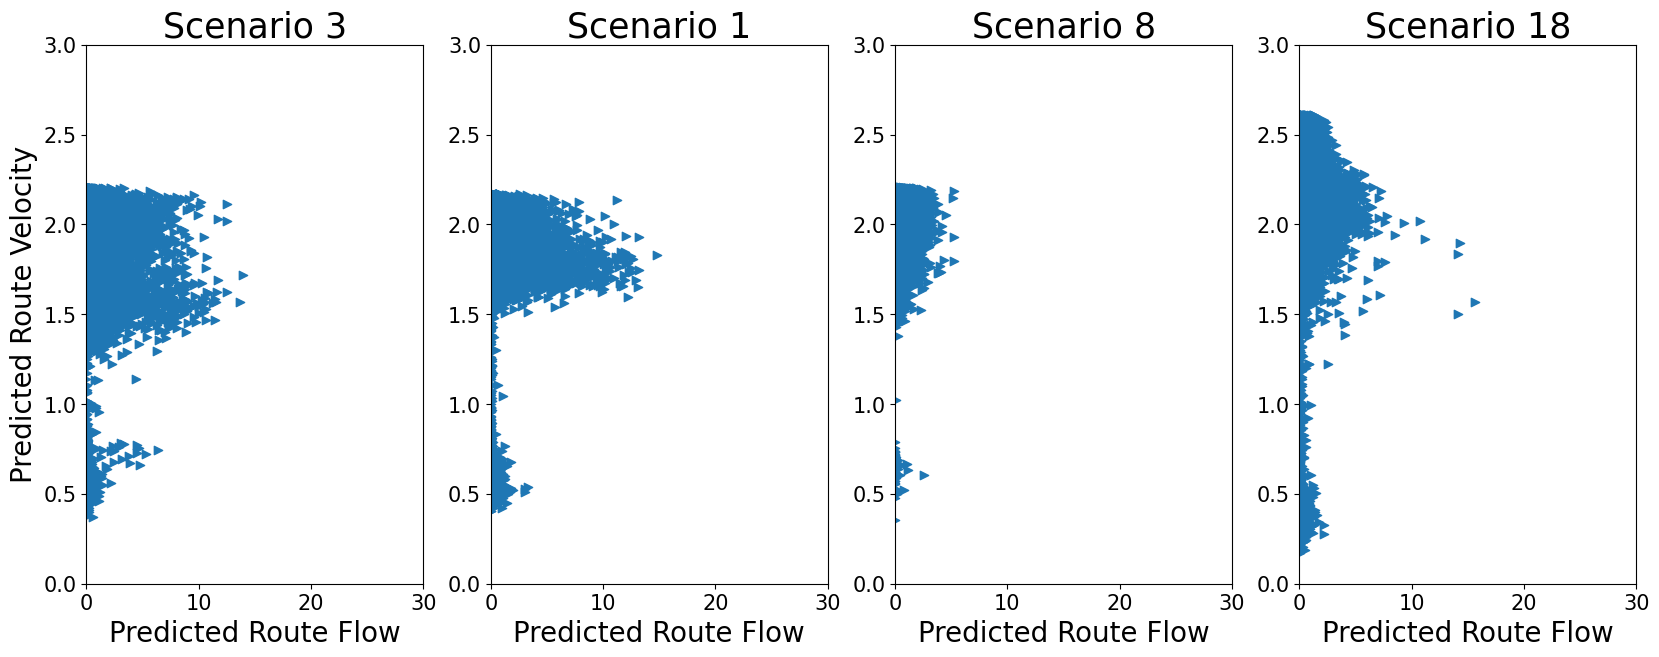

In [29]:
# plot estimated FD
sc_list = ['sc_sensor/maze3', 'sc_sensor/maze1', 'sc_sensor/maze8','sc_sensor/maze18']
# sc_list = ['sc_sensor/train2', 'sc_sensor/train3', 'sc_sensor/train5', 'sc_sensor/train10']
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
i = 0 
for sc in sc_list:
    i = i + 1
    pred_speed = edge_speeds[sc]
    pred_flow = edge_flows[sc]
    axs[sc_list.index(sc)].scatter(pred_flow.reshape(-1), pred_speed.reshape(-1), marker='>')
    name = sc.split("maze")[-1]
    axs[sc_list.index(sc)].set_title(f'Scenario {name}', fontsize=25)
    #ylim
    axs[sc_list.index(sc)].set_ylim(0, 3)
    #xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    if i == 1:
        axs[sc_list.index(sc)].set_ylabel("Predicted Route Velocity", fontsize=20)
    axs[sc_list.index(sc)].set_xlabel("Predicted Route Flow", fontsize=20)
    # x, y ticks
    axs[sc_list.index(sc)].tick_params(axis='x', labelsize=15)
    axs[sc_list.index(sc)].tick_params(axis='y', labelsize=15)
    # axs[sc_list.index(sc)].set_ylabel("Speed", fontsize=15)
# plt.savefig(f"./fig/{dataset_name}_pred_fd.pdf", bbox_inches='tight')

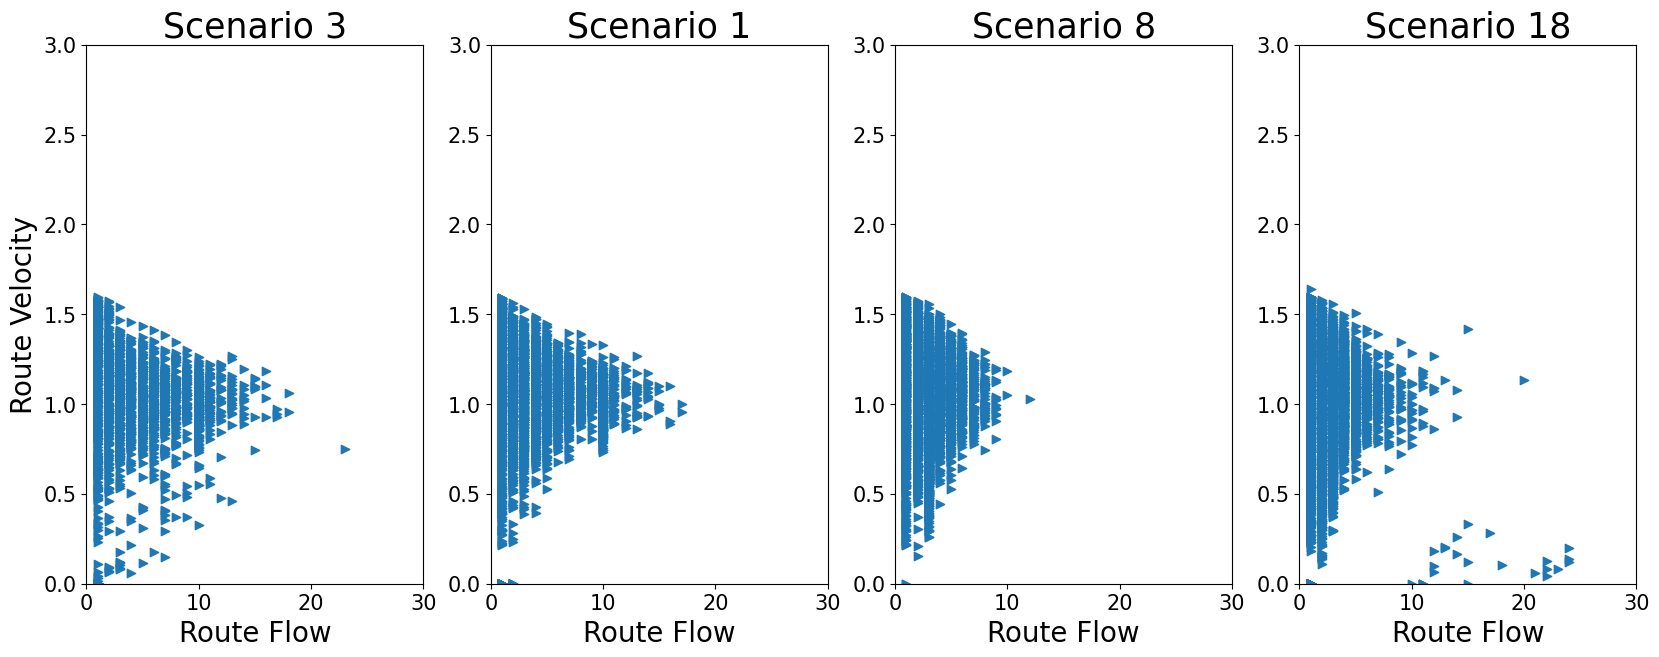

In [32]:
# plot all scenarios
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
i = 0
for sc in sc_list:
    i = i + 1
    fd = fd_all_scenarios[sc]
    sub_df = fd
    flow = sub_df["f"].values
    speed = sub_df["s"].values
    axs[sc_list.index(sc)].scatter(flow, speed, marker='>')
    # ylim
    axs[sc_list.index(sc)].set_ylim(0, 3)
    # xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    name = sc.split("maze")[-1]
    axs[sc_list.index(sc)].set_title(f'Scenario {name}', fontsize=25)
    if i == 1:
        axs[sc_list.index(sc)].set_ylabel("Route Velocity", fontsize=20)
    axs[sc_list.index(sc)].set_xlabel("Route Flow", fontsize=20)
    # x, y ticks
    axs[sc_list.index(sc)].tick_params(axis='x', labelsize=15)
    axs[sc_list.index(sc)].tick_params(axis='y', labelsize=15)
# plt.savefig(f"./fig/{dataset_name}_gt_fd.pdf", bbox_inches='tight')   

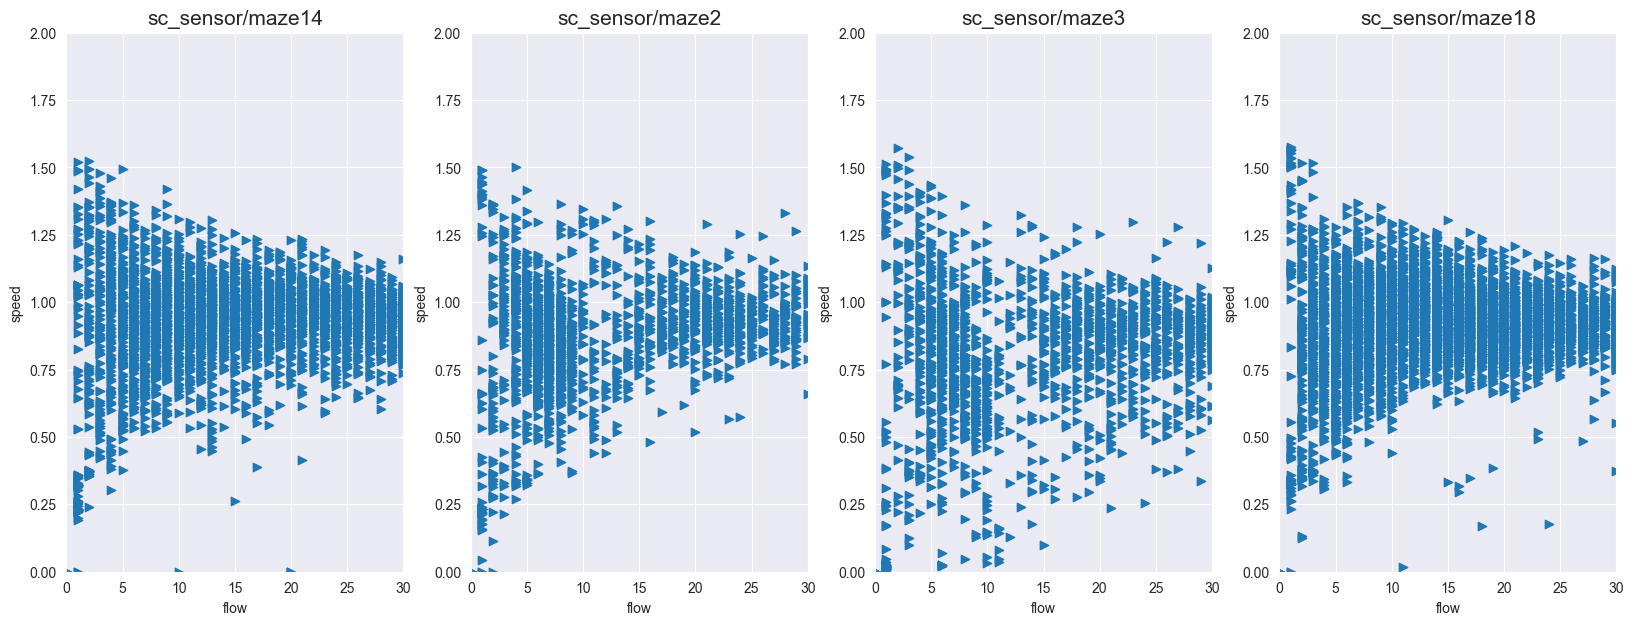

In [290]:
# version 2
fig, axs = plt.subplots(1, len(sc_list), figsize=(20, 7))
for sc in sc_list:
    new_fd = new_fd_data[sc]
    flow = new_fd["flow"].reshape(-1)
    speed = new_fd["speed"].reshape(-1)
    axs[sc_list.index(sc)].scatter(flow, speed, marker='>')
    # ylim
    axs[sc_list.index(sc)].set_ylim(0, 2)
    # xlim
    axs[sc_list.index(sc)].set_xlim(0, 30)
    axs[sc_list.index(sc)].set_title(f'{sc}', fontsize=15)
    axs[sc_list.index(sc)].set_xlabel("flow")
    axs[sc_list.index(sc)].set_ylabel("speed")

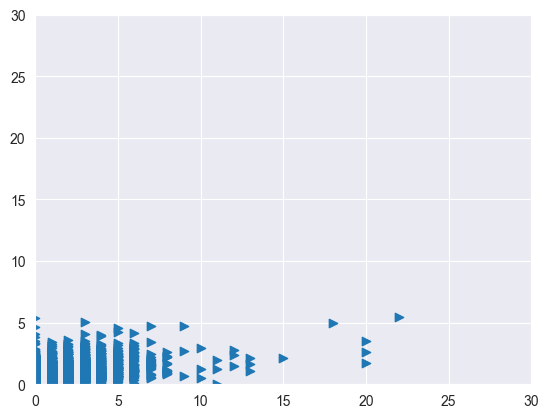

In [138]:
# plot the linear relationship between gt_f and p_f
gt_f = gt_flow[:od_mat.shape[2], :, :].transpose([1, 2, 0]).reshape(-1, od_mat.shape[2])
p_f = od_mat.reshape(-1, od_mat.shape[2])
#xlim
plt.xlim(0, 30)
#ylim
plt.ylim(0, 30)
plt.scatter(gt_f, p_f, marker='>')
plt.show()
